In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

# load explanations

In [2]:
#load explanations

#lime
method='lime'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
n=3000

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_lime = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#kernelshap
method='kernelshap'
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#vanillagrad
method='vanillagrad'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#gradient*input
method='gradtinput'
model_names = ['nn', 'nn_logistic']

filenames = {m: f'explanations/expl_{method}_{m}.pkl' for m in model_names}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}



#integrated gradients
method='integratedgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_integratedgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


#smoothgrad
method='smoothgrad'
model_names = ['nn', 'nn_logistic']
n=1500

filenames = {m: f'explanations/expl_{method}_{m}_n{n}.pkl' for m in model_names}
attr_smoothgrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}


# 1a. calculate topk matrix: functions

In [3]:
#calculate topk agreement, two methods
def calc_topk_agreement_two_methods(attr1, attr2, k, topk_type=['strict', 'lessstrict', 'avgprop']):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #get topk features
    topk1 = np.argsort(-np.abs(attr1), axis=1)[:, 0:k]
    topk2 = np.argsort(-np.abs(attr2), axis=1)[:, 0:k]
    
    if topk_type=='strict':
        #calculate proportion of points where the two explanations are an exact match (topk features: same features, same order)
        boolean_list = np.sum(topk1 == topk2, axis=1) == k #one datapoint = true or false
        metric = np.mean(boolean_list) #proportion of datapoints that meet criteria

    elif topk_type=='lessstrict':
        #calculate proportion of points where the 2 explanations have same features (topk features: same features, order does not matter)
        topk1_sets = [set(row) for row in topk1]
        topk2_sets = [set(row) for row in topk2]
        boolean_list = [setA == setB for setA, setB in zip(topk1_sets, topk2_sets)] #one datapoint = true or false
        metric = np.mean(boolean_list) #proportion of datapoints that meet criteria
        
    elif topk_type=='avgprop':
        #calculate average proportion of shared features among the 2 explanations' top k features        
        topk1_sets = [set(row) for row in topk1]
        topk2_sets = [set(row) for row in topk2]
        metric = [len(setA.intersection(setB))/k for setA, setB in zip(topk1_sets, topk2_sets)] #prop for one datapoint = (#topk features in common)/k
        #metric = np.mean(np.array(prop_common_list)) #average proportion agreement among topk features over all datapoints

    return metric


In [4]:
#calculate topk agreement, all methods
def calc_topk_agreement_all_methods(expl_methods_names, expl_methods_attrs, k, topk_type=['strict', 'lessstrict', 'avgprop']):
    #initiate matrix
    num_expl_methods = len(expl_methods_attrs)
    topk_matrix = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill matrix with pairwise topk agreement
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        #print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        topk_metric = calc_topk_agreement_two_methods(expl_methods_attrs[a], expl_methods_attrs[b], k, topk_type)
        topk_matrix[a, b] = np.mean(topk_metric)
        topk_matrix[b, a] = topk_matrix[a, b]
    
    return topk_matrix


In [5]:
#plot
def plot_matrix1(matrix, plot_path, 
                 labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    mask = np.invert(np.tril(np.ones_like(matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, 
                vmin=0, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels, annot=True, fmt='.4f',
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    plt.tick_params(left=False, bottom=False)
    plt.savefig(plot_path, facecolor='white', transparent=False)

In [6]:
#plot
def plot_matrix5(matrix_list, plot_path, ks,
                 labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):

    
    fig, axes = plt.subplots(1, 5, figsize=(20, 3.5), sharey=True)
    
    for i, k in enumerate(ks):
        mask = np.invert(np.tril(np.ones_like(matrix_list[i], dtype=bool))) #mask for upper triangle
        cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
        sns.heatmap(matrix_list[i], mask=mask, cmap=cmap, 
                    vmin=0, vmax=1, center=0,
                    xticklabels=labels, yticklabels=labels, ax=axes[i],
                    square=True, linewidths=.5, cbar_kws={'shrink': 0.80}).set_title(f'k = {k}')
        axes[i].tick_params(left=False, bottom=False)
    
        axes[i].set_yticklabels(labels, rotation=0)
    
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')

In [7]:
#full analysis function: plot one matrix
def topk_analysis_matrix1(expl_methods_names, expl_methods_attrs, k, plot_path, 
                          topk_type=['strict', 'lessstrict', 'avgprop'],
                          labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    #topk analysis
    topk_matrix = calc_topk_agreement_all_methods(expl_methods_names, expl_methods_attrs, k, topk_type)
    #plot
    plot_matrix1(topk_matrix, plot_path, labels)
    
    return topk_matrix

In [8]:
#full analysis function: plot 5 matrices
def topk_analysis_matrix5(expl_methods_names, expl_methods_attrs, ks, plot_path, 
                          topk_type=['strict', 'lessstrict', 'avgprop'],
                          labels=['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD']):
    #topk analysis
    matrix_list=[]
    for k in ks:
        #heatmap
        matrix = calc_topk_agreement_all_methods(expl_methods_names, expl_methods_attrs, k, topk_type)
        matrix_list.append(matrix)
    
    #plot
    plot_matrix5(matrix_list, plot_path, ks, labels)
    
    return matrix_list

# 1b. calculate topk matrix: results

### NN + logistic

top k analysis: strict, nn, k=[1, 2, 3, 4, 5]
top k analysis: strict, nn, k=1
top k analysis: strict, nn, k=2
top k analysis: strict, nn, k=3
top k analysis: strict, nn, k=4
top k analysis: strict, nn, k=5
top k analysis: strict, nn, k=6
top k analysis: strict, nn, k=7
top k analysis: lessstrict, nn, k=[1, 2, 3, 4, 5]
top k analysis: lessstrict, nn, k=1
top k analysis: lessstrict, nn, k=2
top k analysis: lessstrict, nn, k=3
top k analysis: lessstrict, nn, k=4
top k analysis: lessstrict, nn, k=5
top k analysis: lessstrict, nn, k=6
top k analysis: lessstrict, nn, k=7
top k analysis: avgprop, nn, k=[1, 2, 3, 4, 5]
top k analysis: avgprop, nn, k=1
top k analysis: avgprop, nn, k=2
top k analysis: avgprop, nn, k=3
top k analysis: avgprop, nn, k=4


<ipython-input-5-0239f5d6efea>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 7))


top k analysis: avgprop, nn, k=5
top k analysis: avgprop, nn, k=6
top k analysis: avgprop, nn, k=7
top k analysis: strict, nn_logistic, k=[1, 2, 3, 4, 5]
top k analysis: strict, nn_logistic, k=1
top k analysis: strict, nn_logistic, k=2
top k analysis: strict, nn_logistic, k=3
top k analysis: strict, nn_logistic, k=4
top k analysis: strict, nn_logistic, k=5
top k analysis: strict, nn_logistic, k=6
top k analysis: strict, nn_logistic, k=7
top k analysis: lessstrict, nn_logistic, k=[1, 2, 3, 4, 5]
top k analysis: lessstrict, nn_logistic, k=1
top k analysis: lessstrict, nn_logistic, k=2
top k analysis: lessstrict, nn_logistic, k=3
top k analysis: lessstrict, nn_logistic, k=4
top k analysis: lessstrict, nn_logistic, k=5
top k analysis: lessstrict, nn_logistic, k=6
top k analysis: lessstrict, nn_logistic, k=7
top k analysis: avgprop, nn_logistic, k=[1, 2, 3, 4, 5]
top k analysis: avgprop, nn_logistic, k=1
top k analysis: avgprop, nn_logistic, k=2
top k analysis: avgprop, nn_logistic, k=3
top

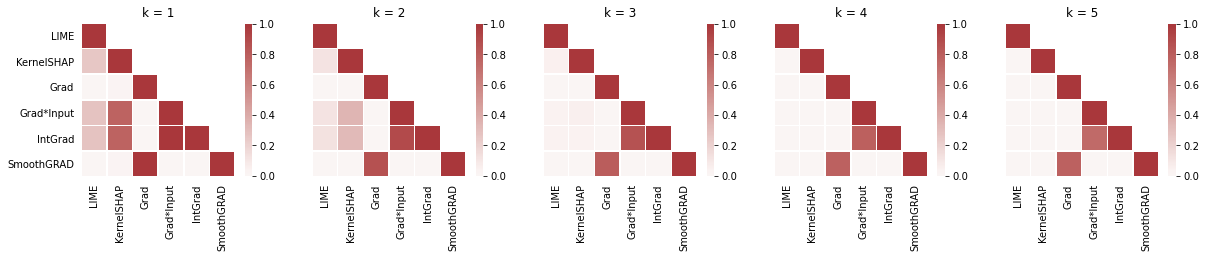

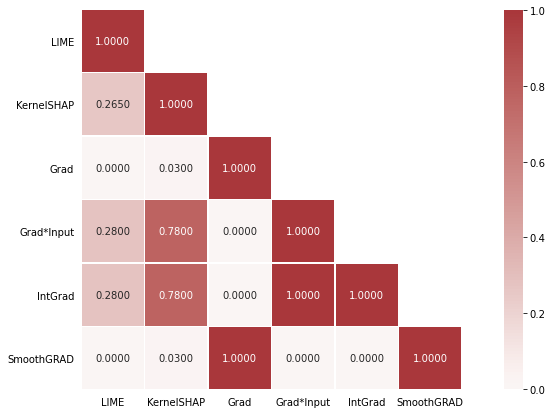

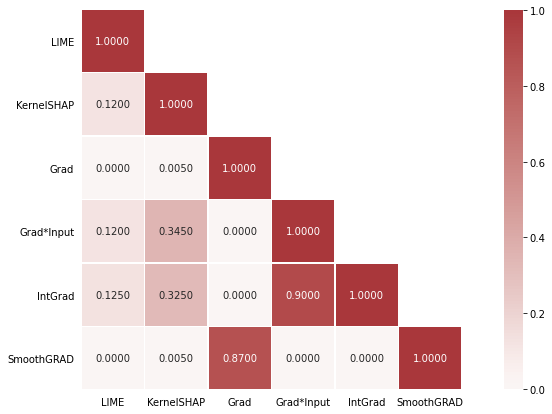

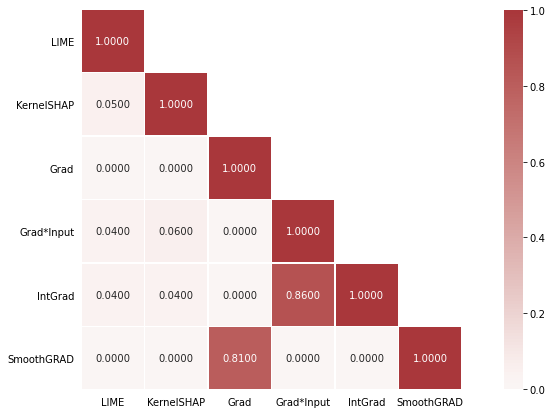

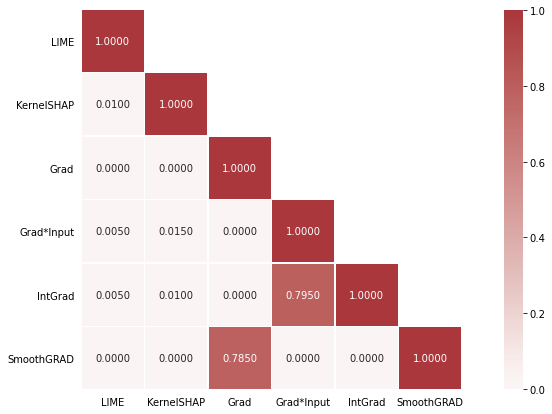

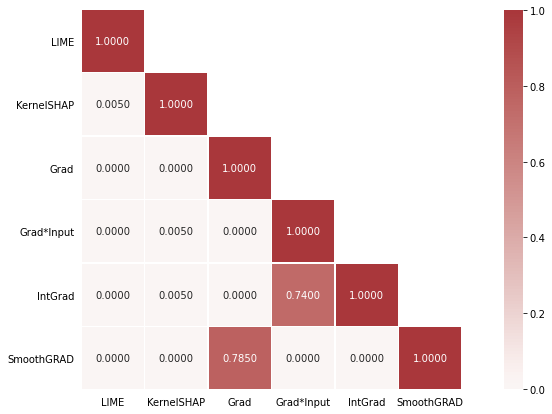

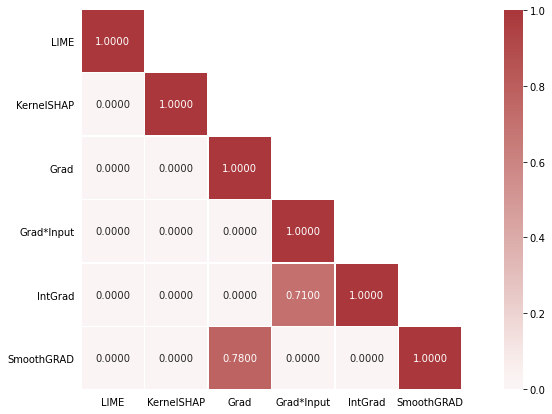

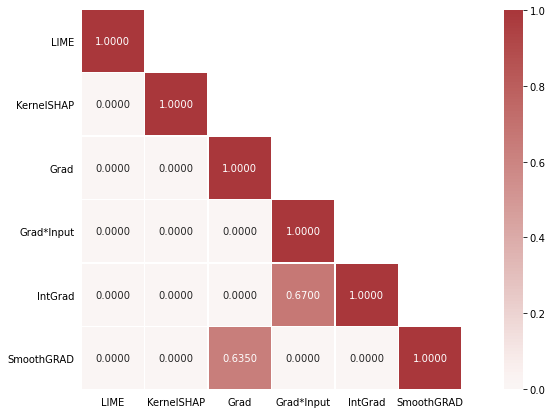

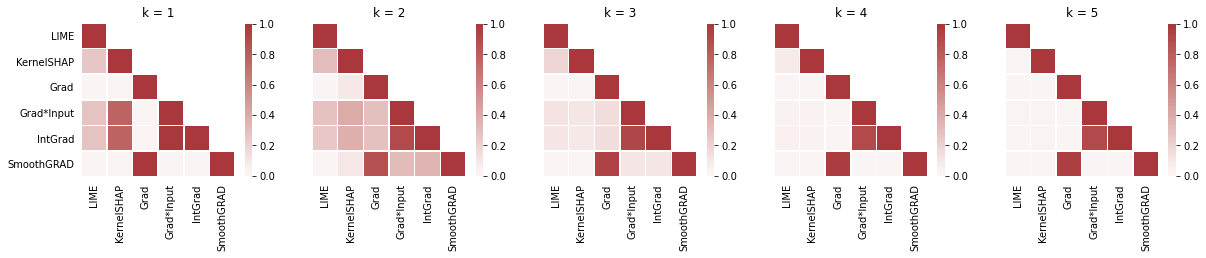

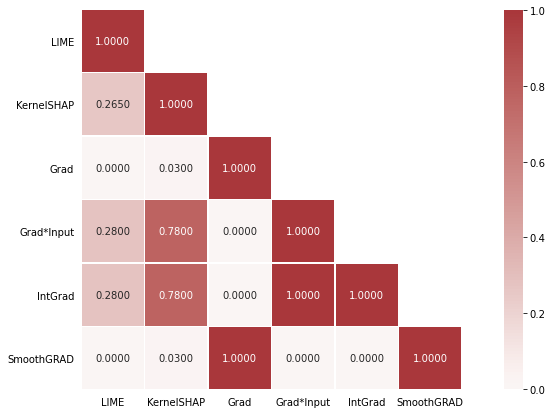

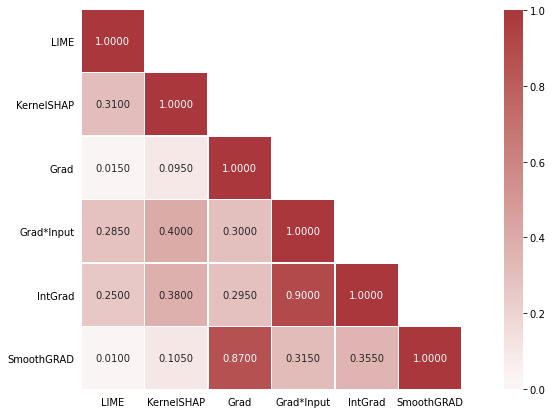

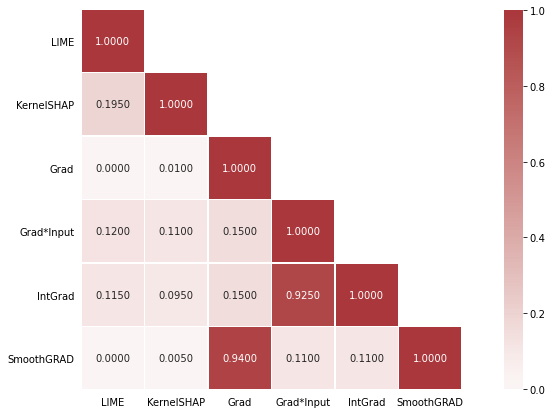

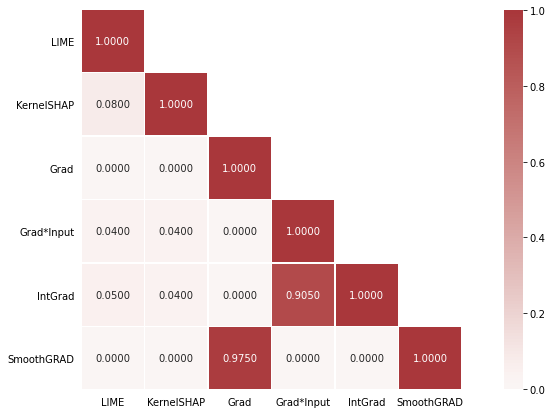

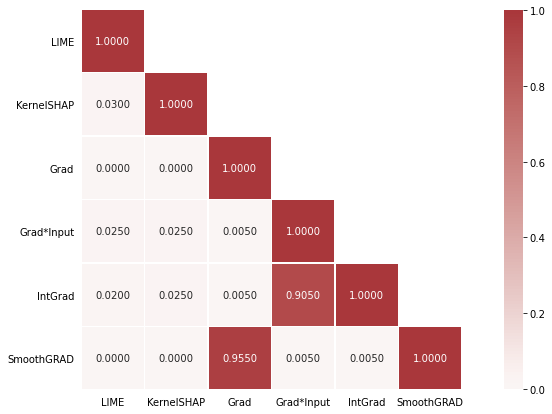

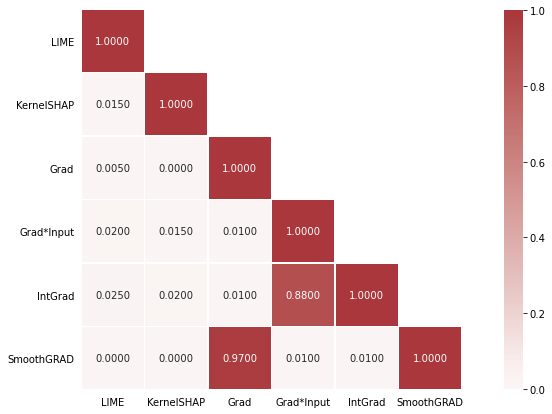

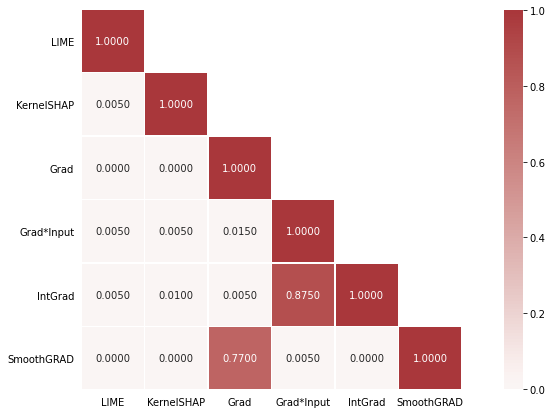

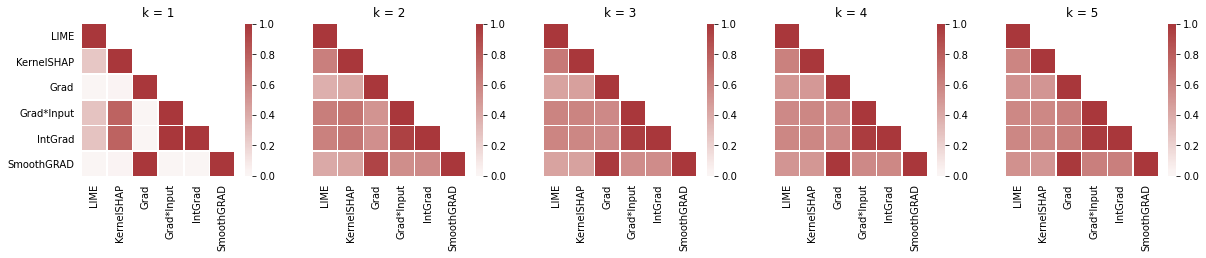

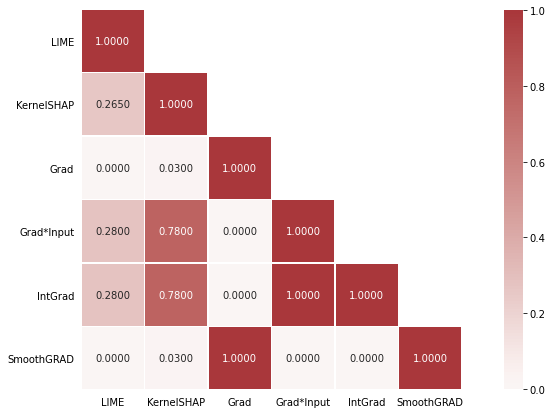

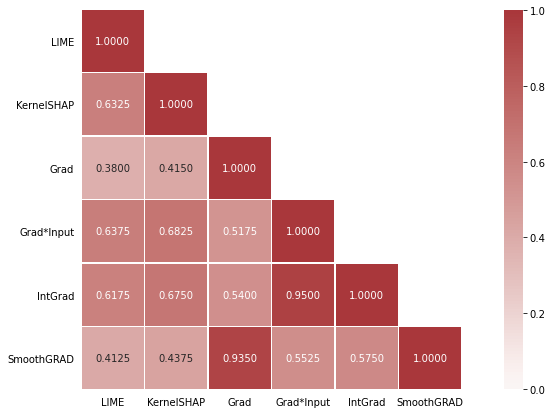

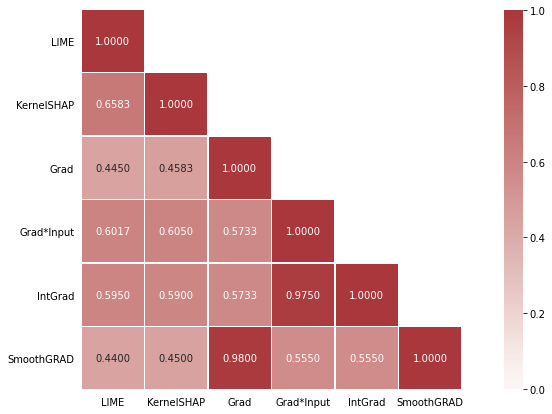

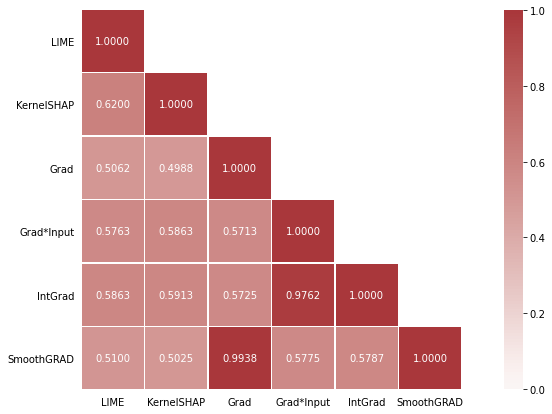

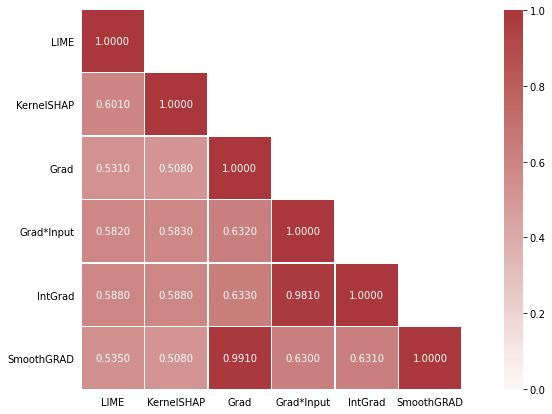

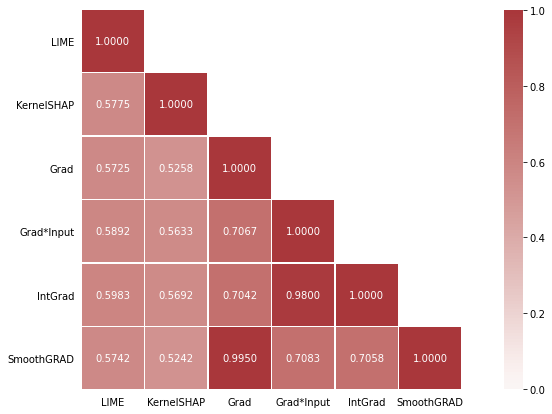

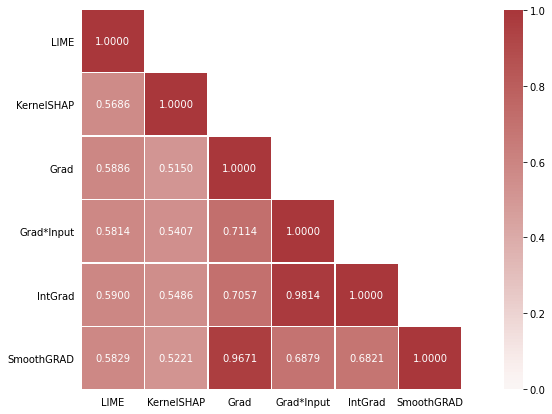

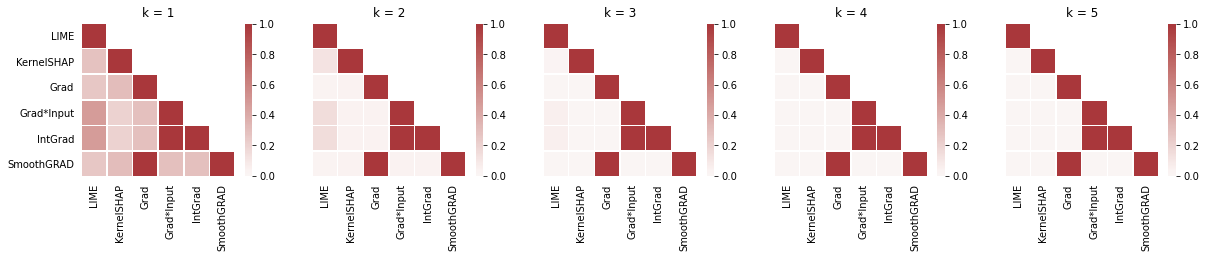

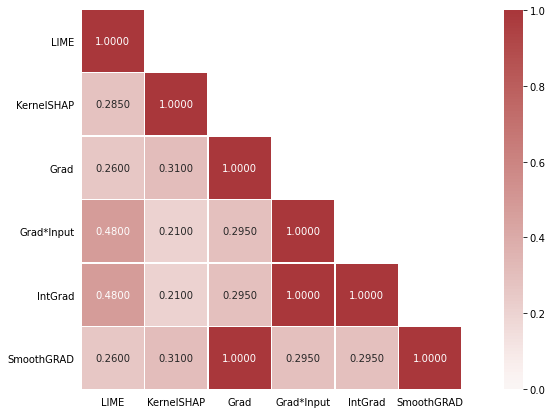

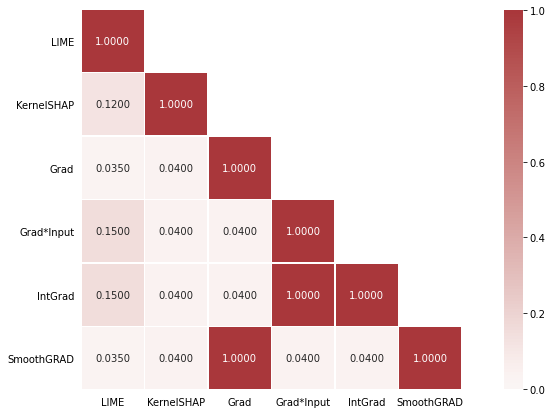

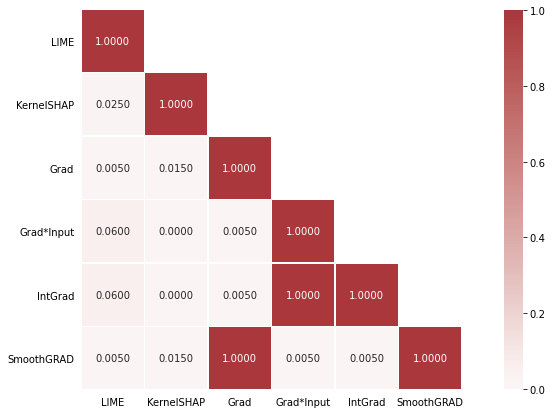

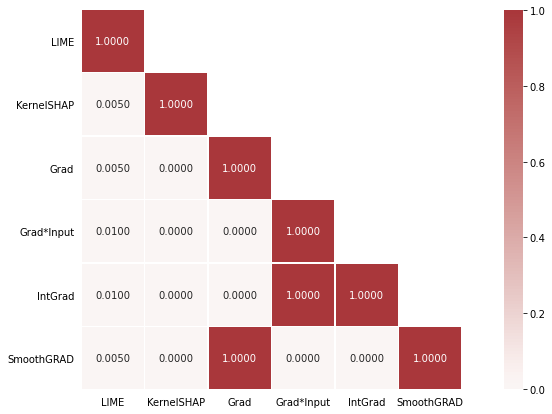

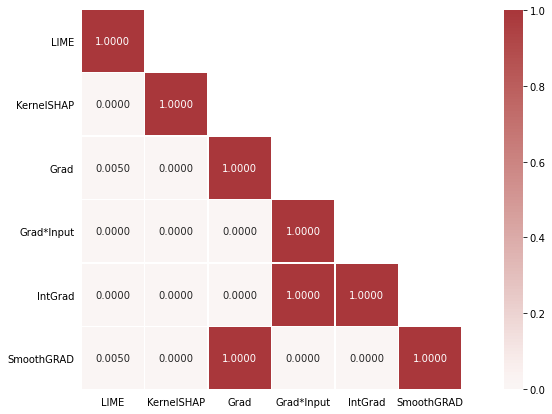

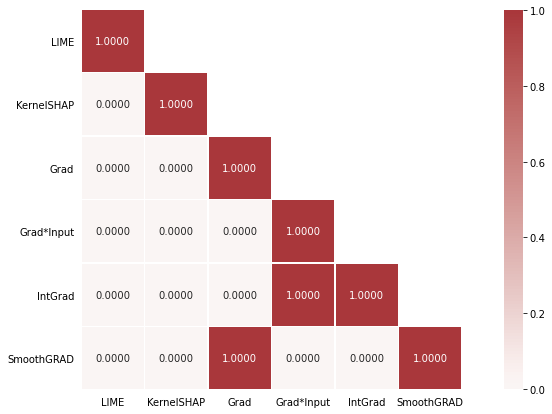

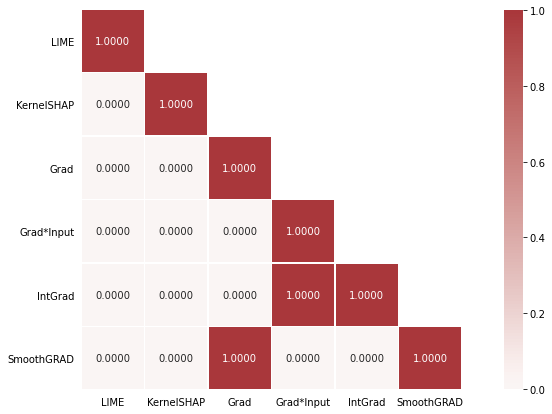

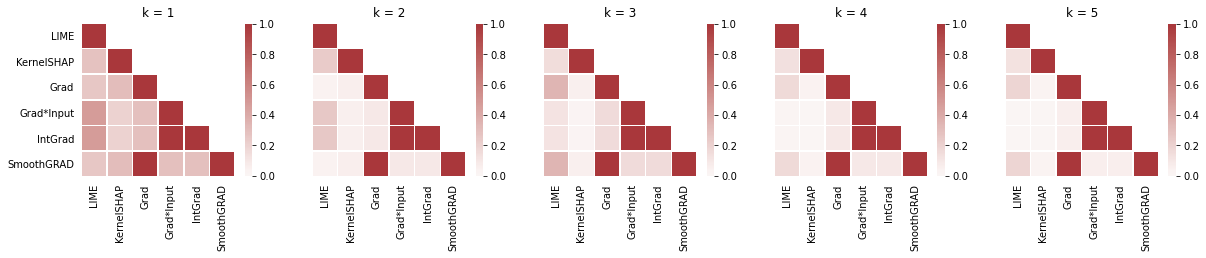

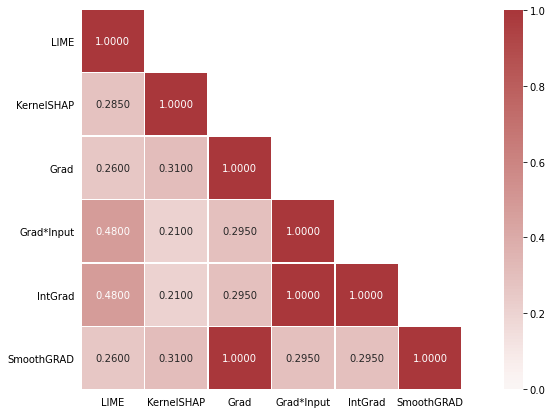

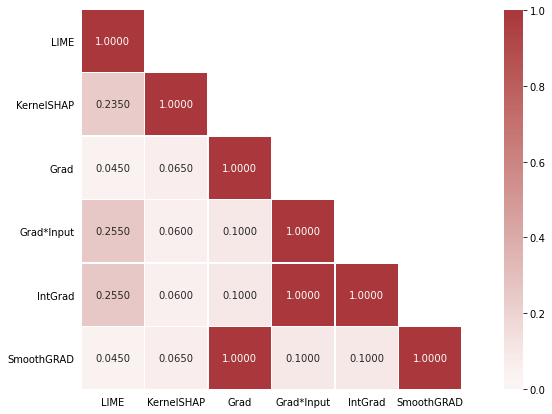

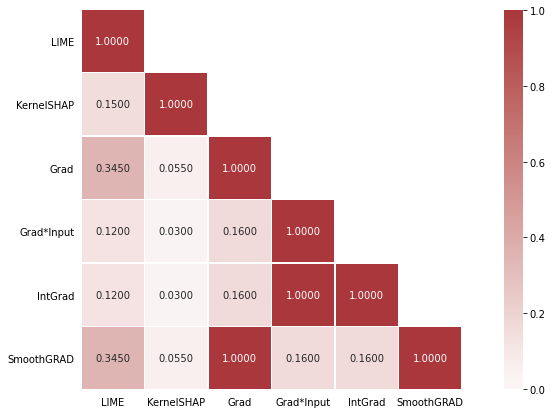

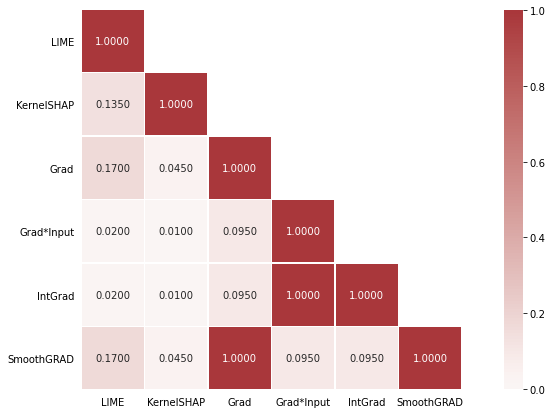

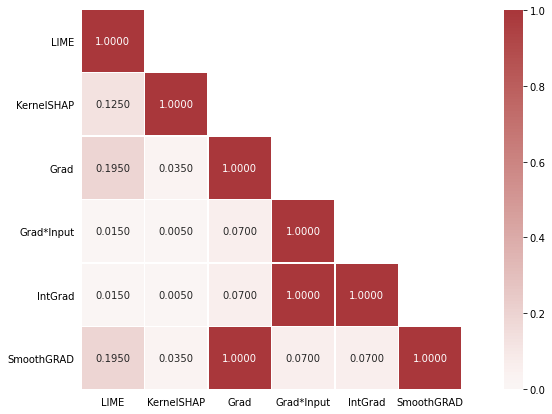

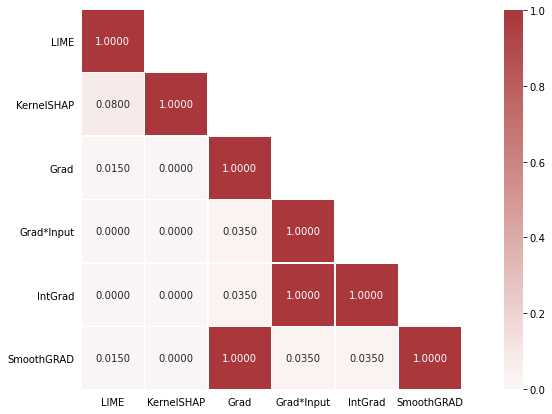

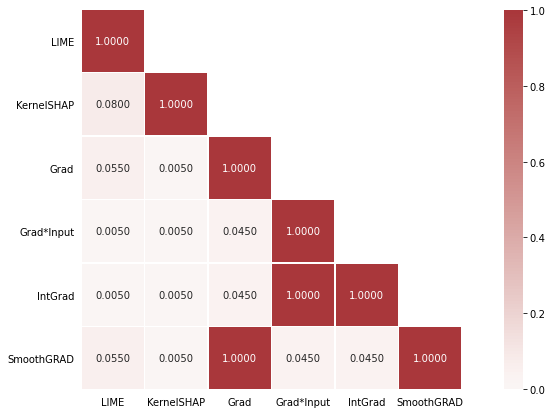

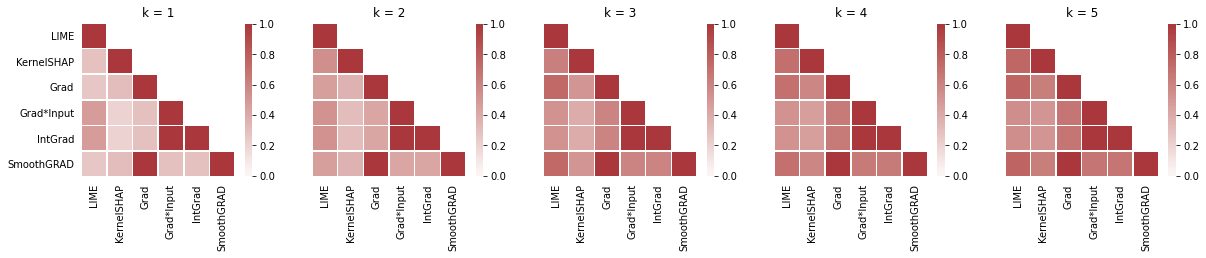

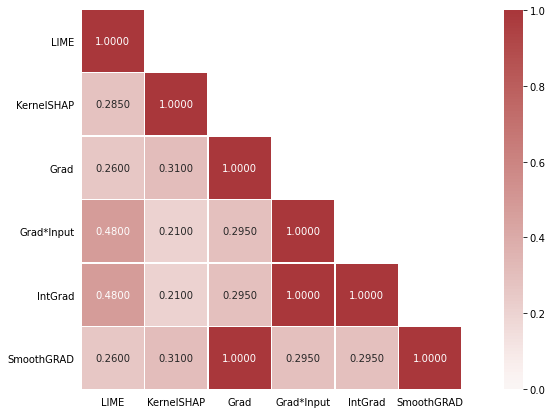

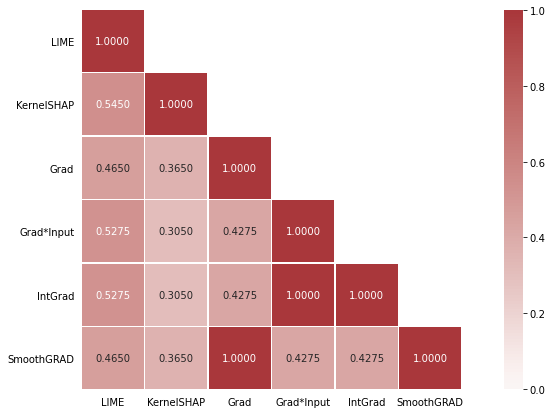

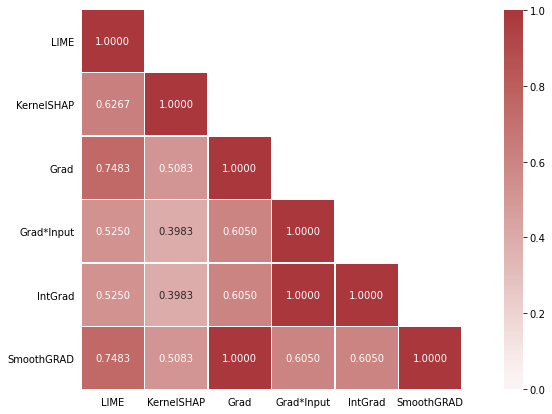

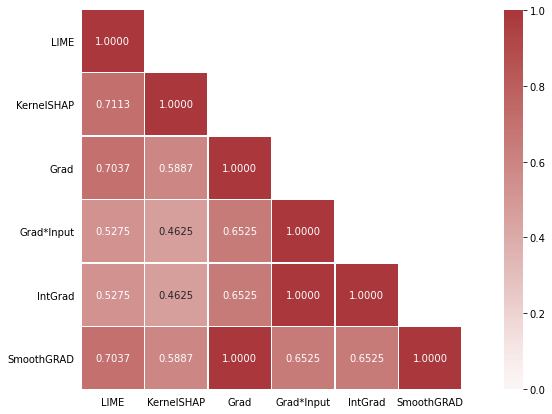

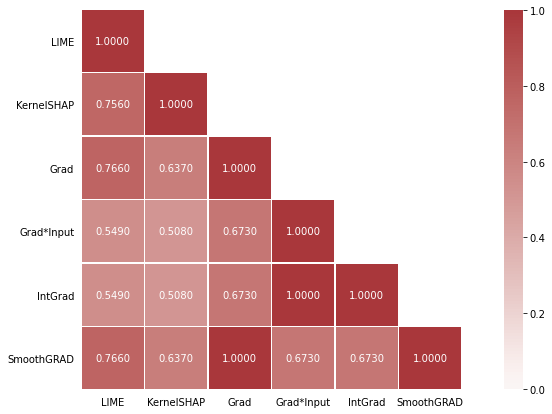

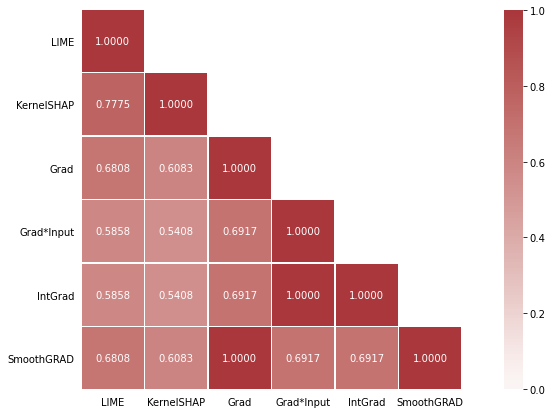

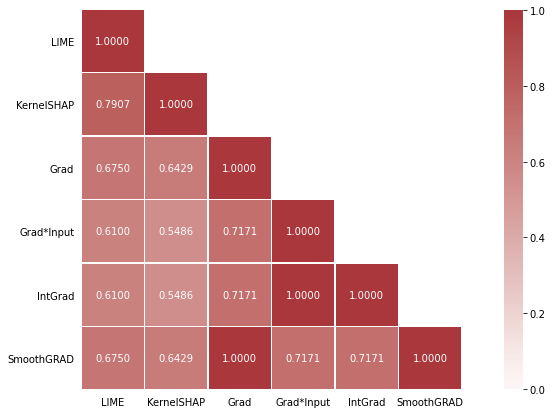

In [9]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
max_k=7
ks=[1, 2, 3, 4, 5]

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    for metric in ['strict', 'lessstrict', 'avgprop']:
        #5 k values
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_{metric}_{m}_ks_{ks[0]}_{ks[1]}_{ks[2]}_{ks[3]}_{ks[4]}.png'
        matrix_list = topk_analysis_matrix5(expl_methods_names, expl_methods_attrs, ks, plot_path, 
                              topk_type=metric)
        
        #single k's
        for k_i in range(1, max_k+1):
            print(f'top k analysis: {metric}, {m}, k={k_i}')
            plot_path=f'figures/topk_{metric}_{m}_k{k_i}.png'
            topk_matrix = topk_analysis_matrix1(expl_methods_names, expl_methods_attrs, 
                                                k=k_i, plot_path=plot_path, topk_type=metric)

### RF + GB

top k analysis: strict, rf, k=[1, 2, 3, 4, 5]
top k analysis: strict, rf, k=1
top k analysis: strict, rf, k=2
top k analysis: strict, rf, k=3
top k analysis: strict, rf, k=4
top k analysis: strict, rf, k=5
top k analysis: strict, rf, k=6
top k analysis: strict, rf, k=7
top k analysis: lessstrict, rf, k=[1, 2, 3, 4, 5]
top k analysis: lessstrict, rf, k=1
top k analysis: lessstrict, rf, k=2
top k analysis: lessstrict, rf, k=3
top k analysis: lessstrict, rf, k=4
top k analysis: lessstrict, rf, k=5
top k analysis: lessstrict, rf, k=6
top k analysis: lessstrict, rf, k=7
top k analysis: avgprop, rf, k=[1, 2, 3, 4, 5]
top k analysis: avgprop, rf, k=1
top k analysis: avgprop, rf, k=2
top k analysis: avgprop, rf, k=3
top k analysis: avgprop, rf, k=4
top k analysis: avgprop, rf, k=5
top k analysis: avgprop, rf, k=6


<ipython-input-5-0239f5d6efea>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 7))


top k analysis: avgprop, rf, k=7
top k analysis: strict, gb, k=[1, 2, 3, 4, 5]
top k analysis: strict, gb, k=1
top k analysis: strict, gb, k=2
top k analysis: strict, gb, k=3
top k analysis: strict, gb, k=4
top k analysis: strict, gb, k=5
top k analysis: strict, gb, k=6
top k analysis: strict, gb, k=7
top k analysis: lessstrict, gb, k=[1, 2, 3, 4, 5]
top k analysis: lessstrict, gb, k=1
top k analysis: lessstrict, gb, k=2
top k analysis: lessstrict, gb, k=3
top k analysis: lessstrict, gb, k=4
top k analysis: lessstrict, gb, k=5
top k analysis: lessstrict, gb, k=6
top k analysis: lessstrict, gb, k=7
top k analysis: avgprop, gb, k=[1, 2, 3, 4, 5]
top k analysis: avgprop, gb, k=1
top k analysis: avgprop, gb, k=2
top k analysis: avgprop, gb, k=3
top k analysis: avgprop, gb, k=4
top k analysis: avgprop, gb, k=5
top k analysis: avgprop, gb, k=6
top k analysis: avgprop, gb, k=7


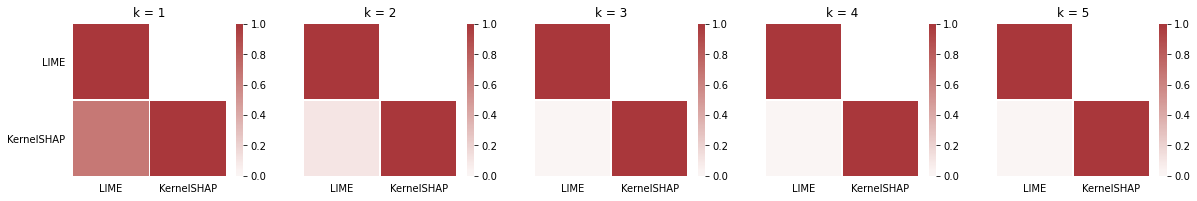

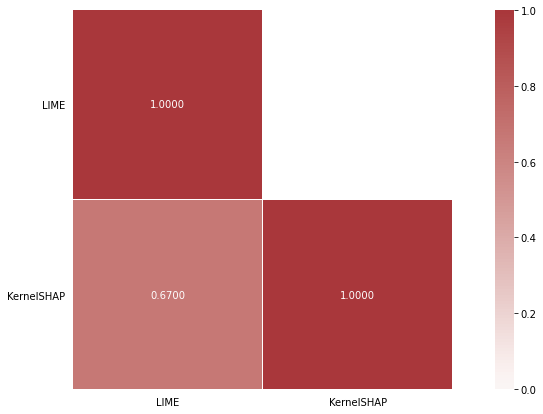

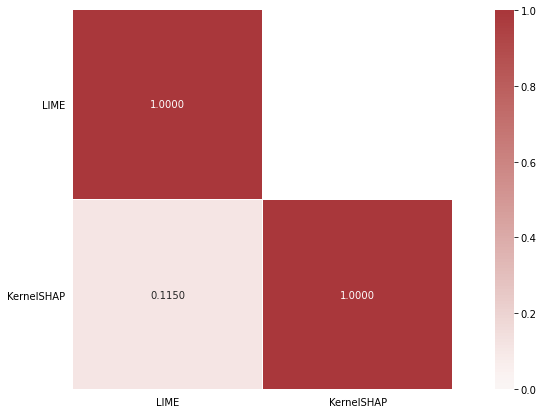

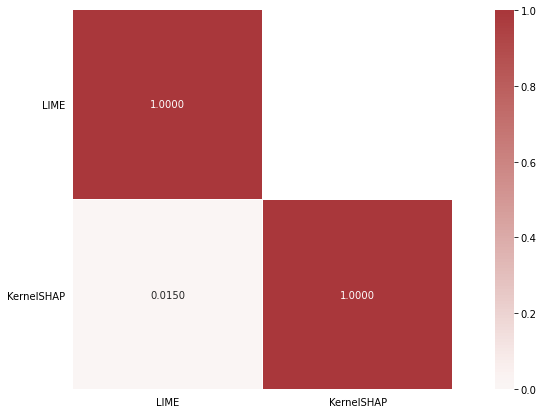

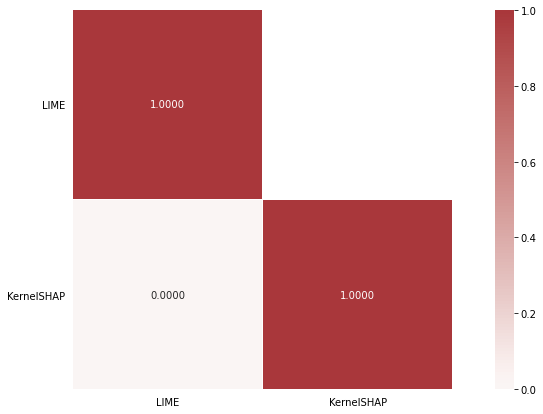

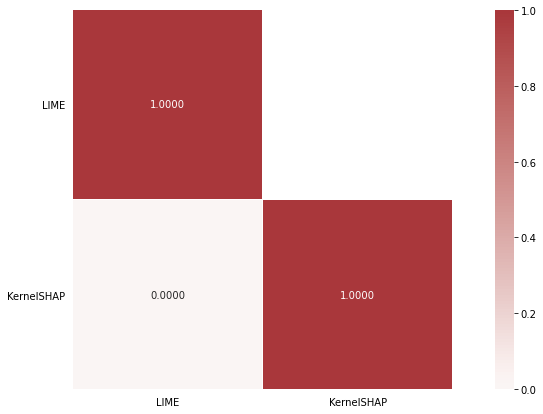

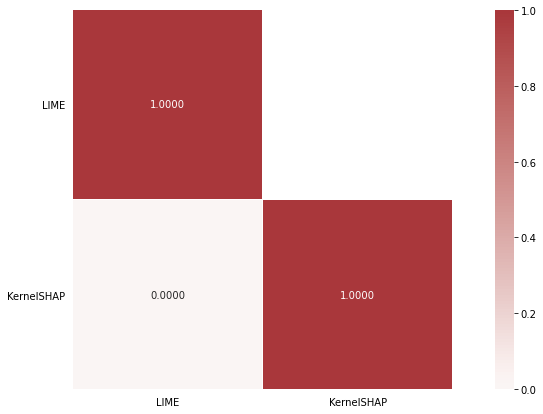

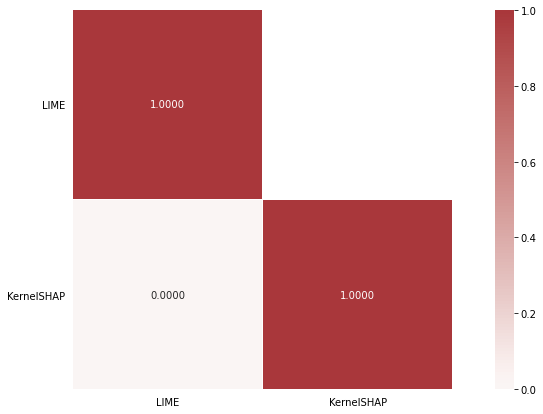

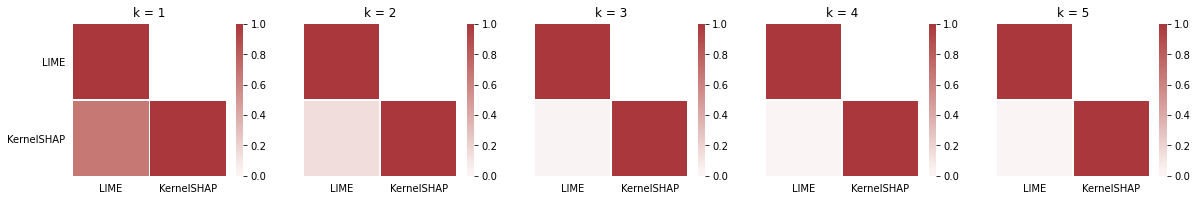

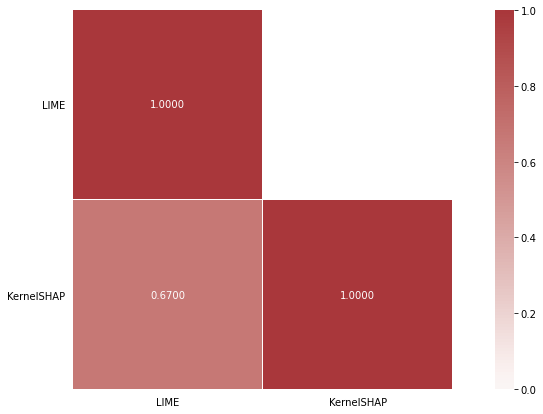

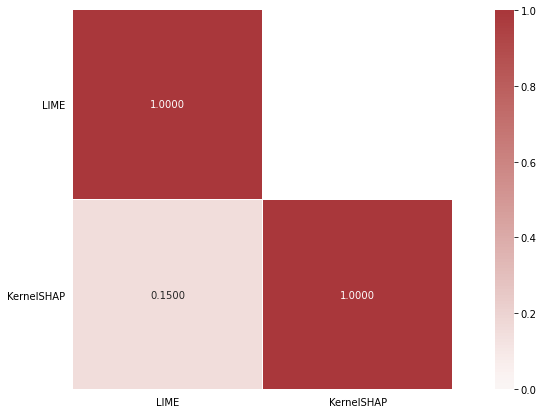

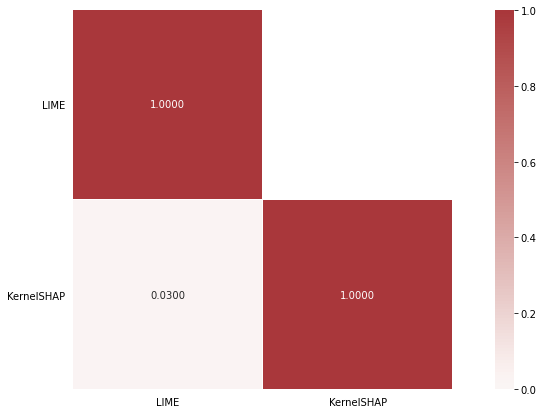

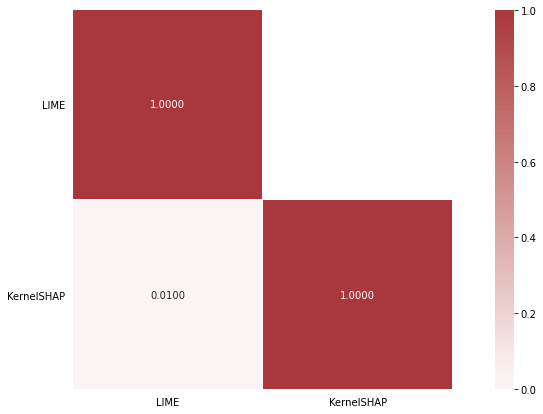

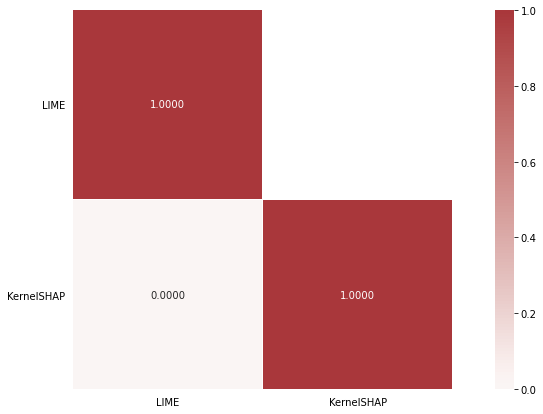

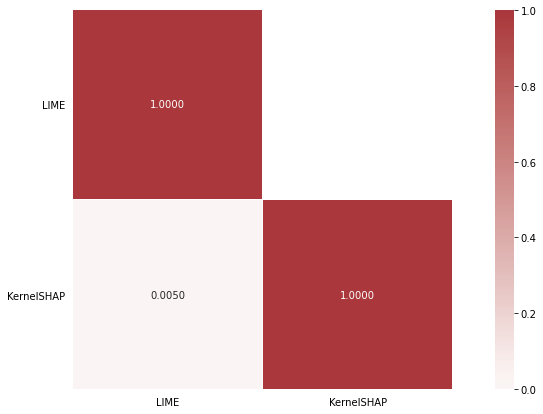

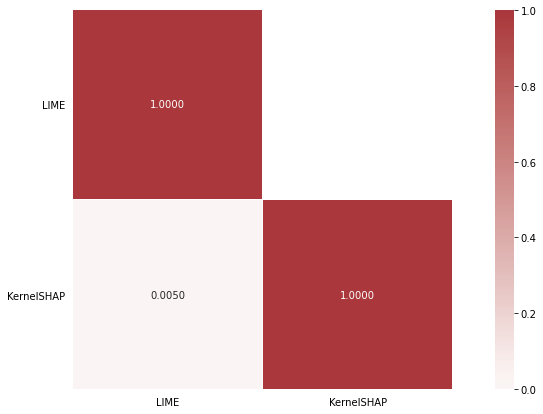

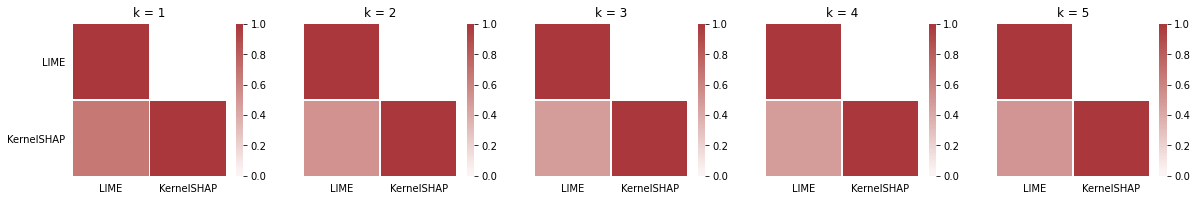

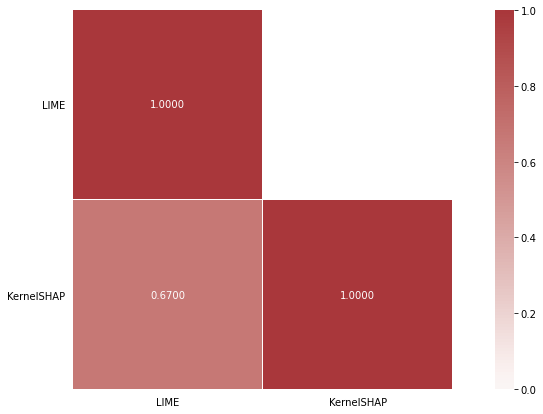

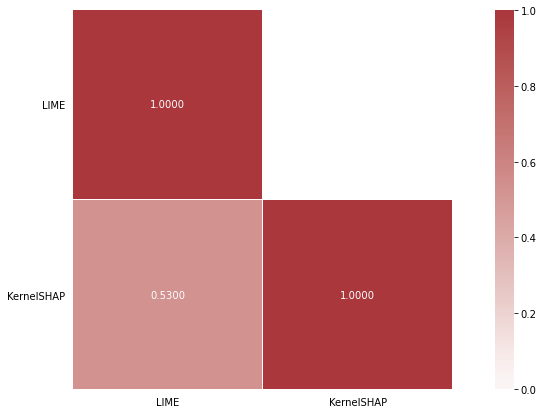

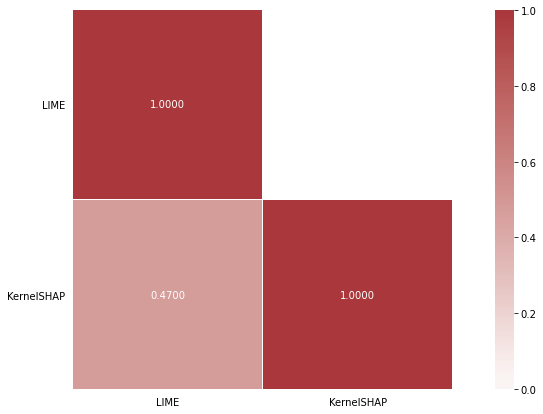

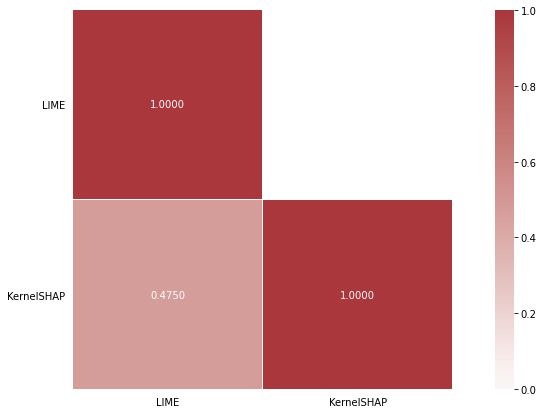

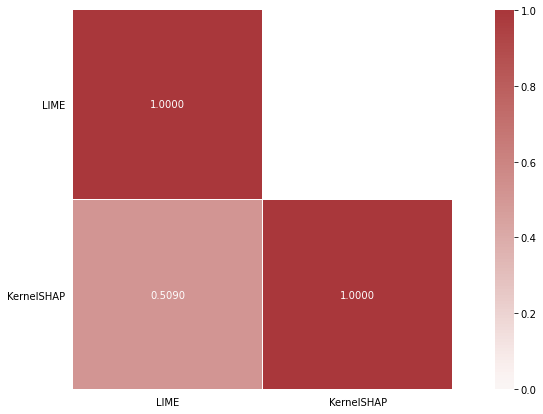

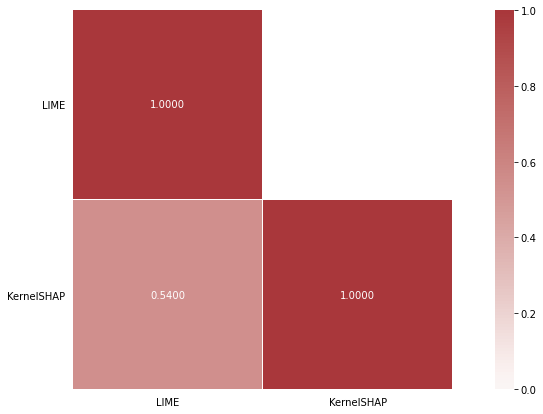

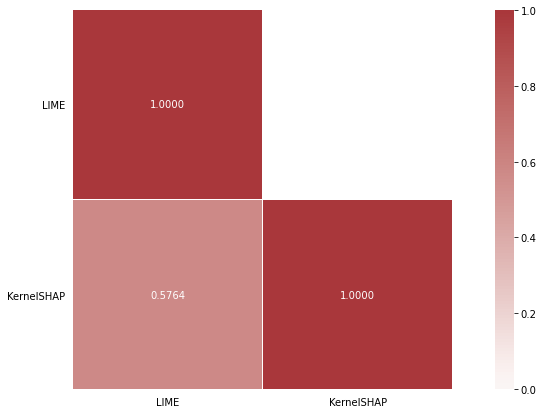

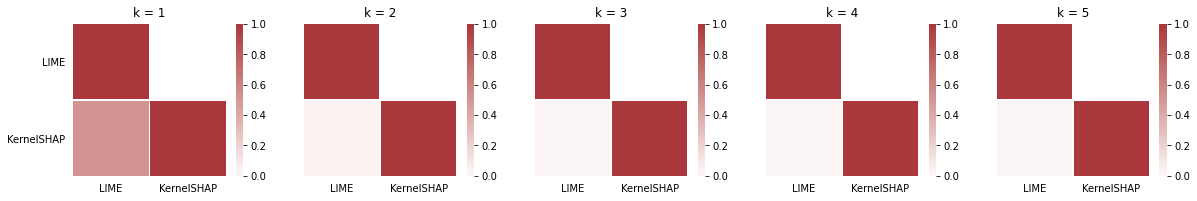

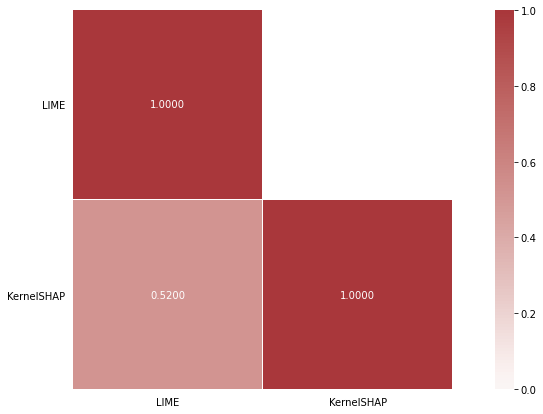

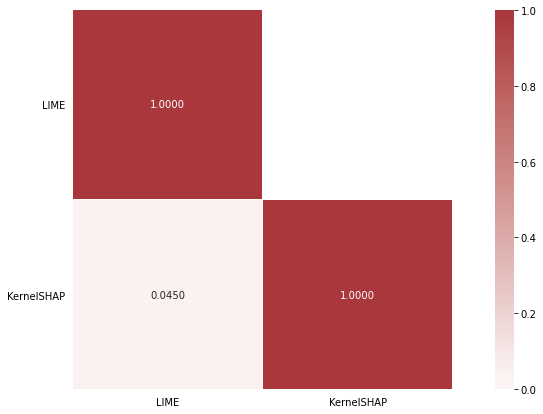

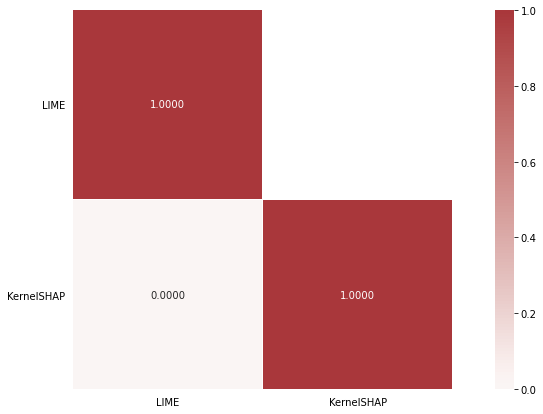

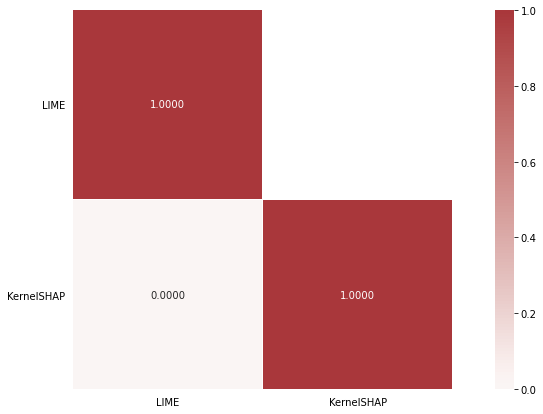

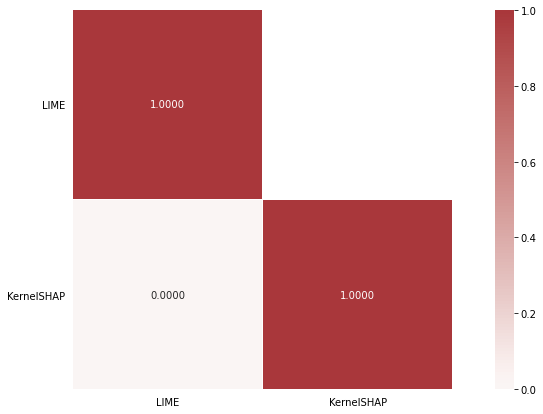

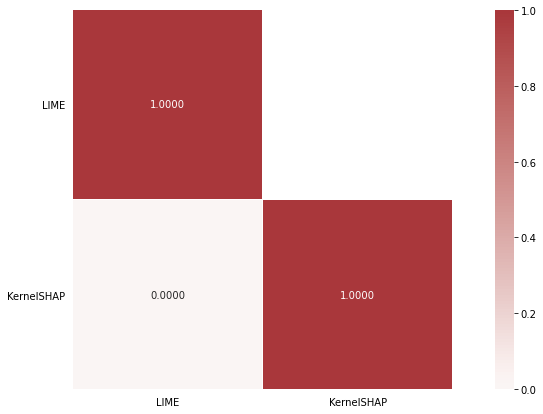

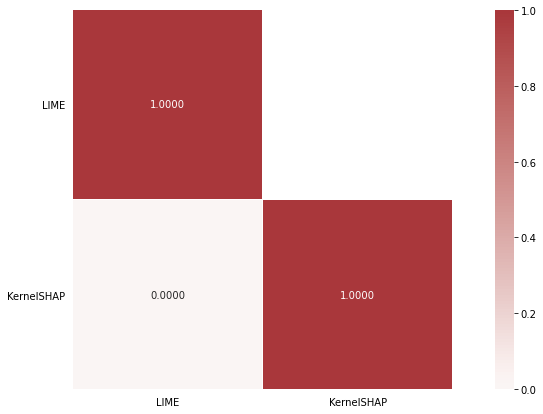

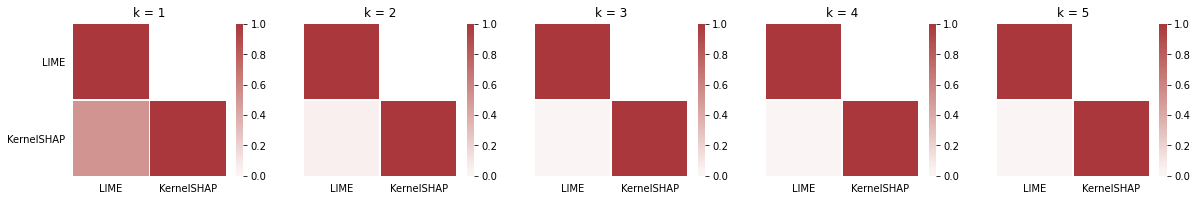

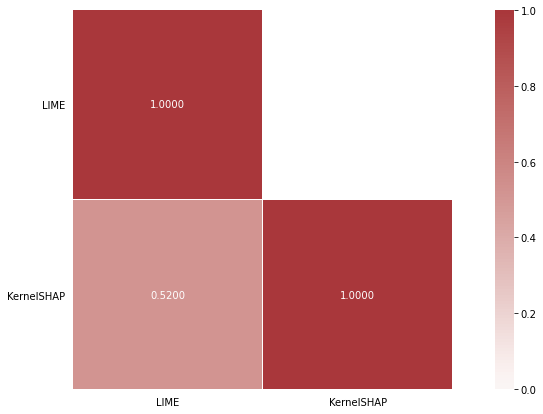

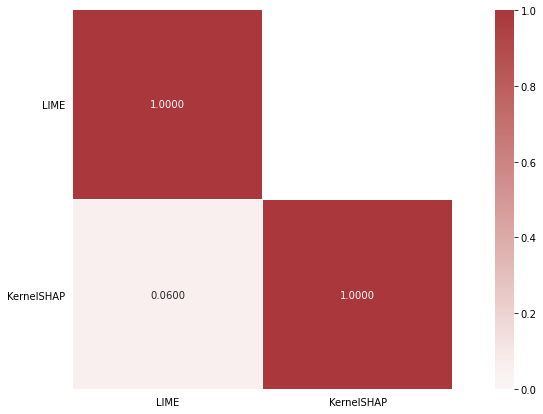

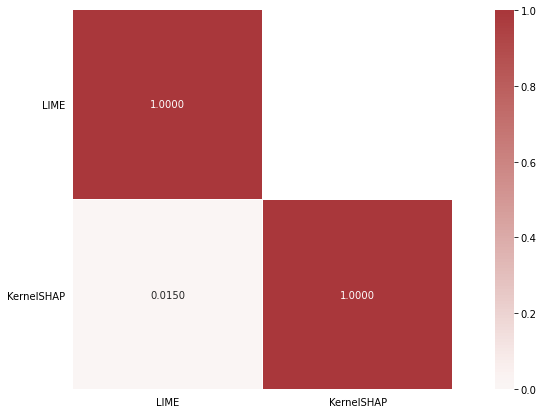

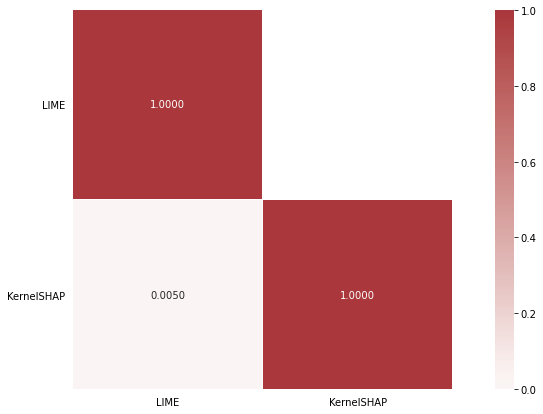

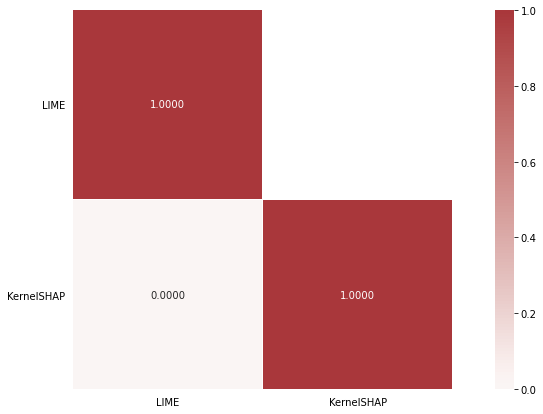

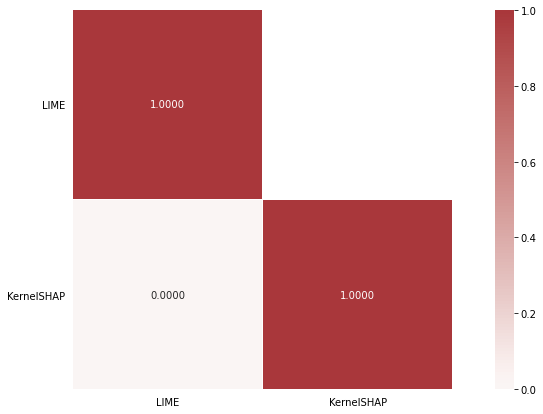

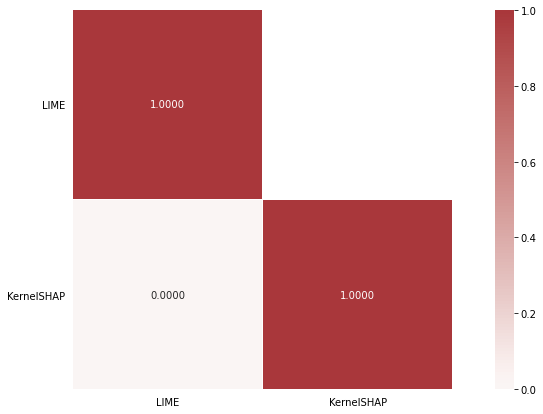

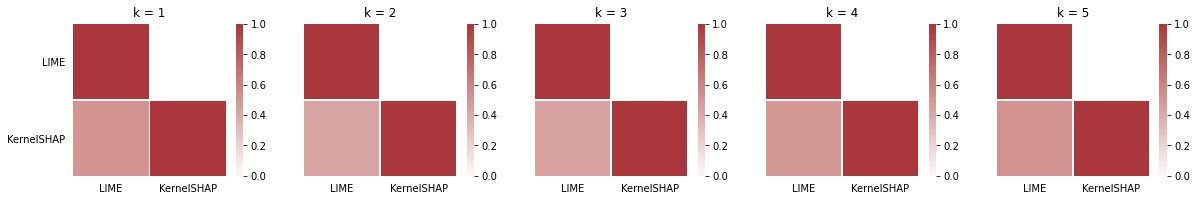

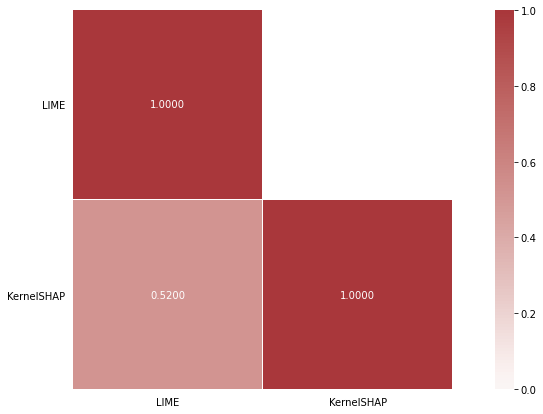

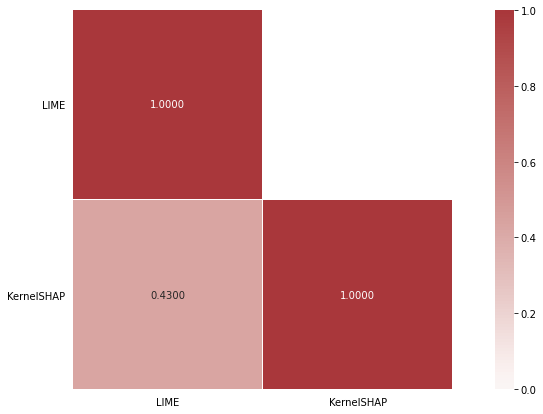

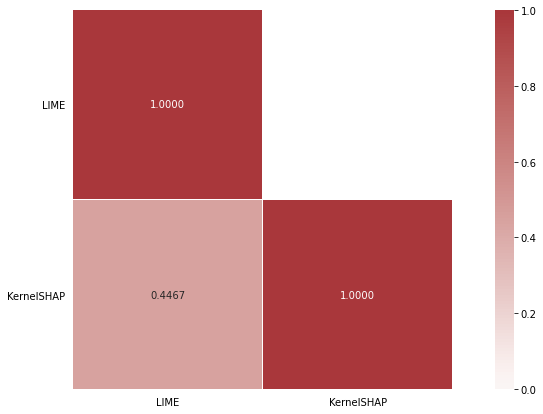

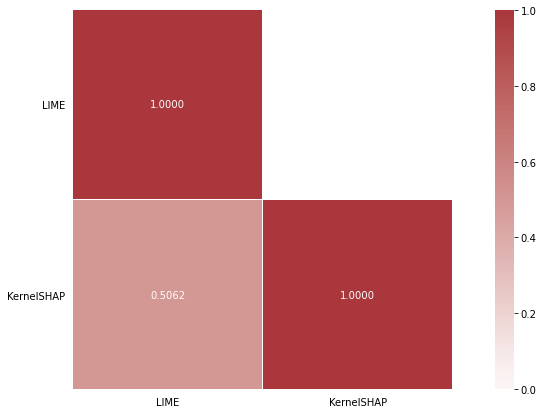

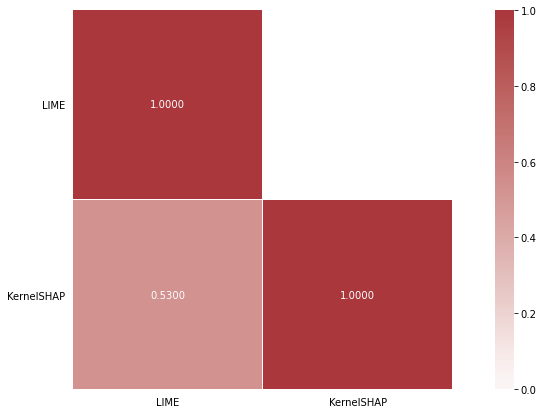

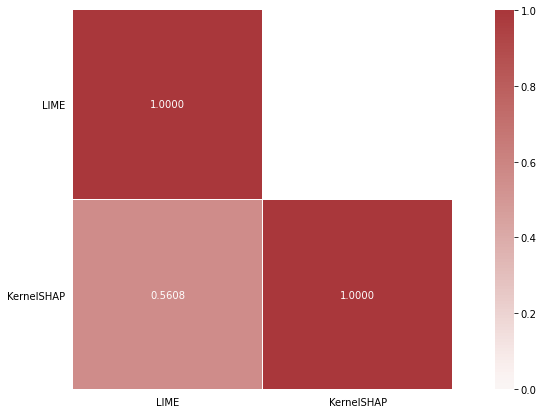

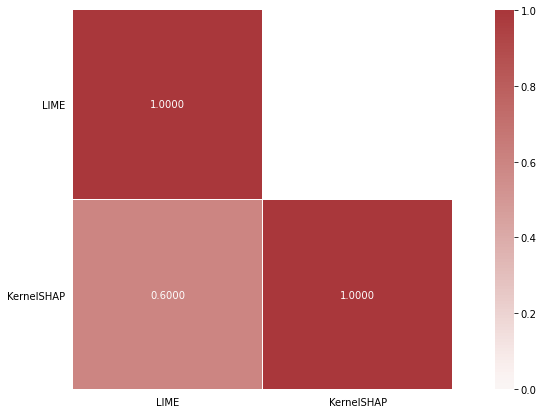

In [10]:
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
max_k=7
ks=[1, 2, 3, 4, 5]
labels=['LIME', 'KernelSHAP']

for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    for metric in ['strict', 'lessstrict', 'avgprop']:
        #5 k values
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_{metric}_{m}_ks_{ks[0]}_{ks[1]}_{ks[2]}_{ks[3]}_{ks[4]}.png'
        matrix_list = topk_analysis_matrix5(expl_methods_names, expl_methods_attrs, ks, plot_path, 
                              topk_type=metric, labels=labels)
        
        #single k's
        for k_i in range(1, max_k+1):
            print(f'top k analysis: {metric}, {m}, k={k_i}')
            plot_path=f'figures/topk_{metric}_{m}_k{k_i}.png'
            topk_matrix = topk_analysis_matrix1(expl_methods_names, expl_methods_attrs, 
                                                k=k_i, plot_path=plot_path, topk_type=metric, labels=labels)

# 2a. calculate topk metrics for barplot

In [11]:
#calculate topk agreement, all methods
def calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks, topk_type=['strict', 'lessstrict', 'avgprop']):
    #initiate matrix
    num_expl_methods = len(expl_methods_attrs)
    
    #fill matrix with pairwise topk agreement
    metrics_dict = {}
    for a, b in itertools.combinations(range(num_expl_methods), 2):
        metrics_list = []
        for k in ks:
            topk_metric = calc_topk_agreement_two_methods(expl_methods_attrs[a], expl_methods_attrs[b], k, topk_type)
            metrics_list.append(topk_metric)
        metrics_dict[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = metrics_list
            
    return metrics_dict



In [12]:
def plot_topk_barplots(expl_methods_names, expl_methods_attrs, ks, plot_path, topk_type=['strict', 'lessstrict']):
    #calculate values for plotting
    metrics_dict = calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks, topk_type)
    
    #plot
    fig, axes = plt.subplots(3, 5, figsize =(20, 8))
    for i, ax in enumerate(axes.flat):
        title, metric_values = list(metrics_dict.items())[i]
        sns.barplot(x=ks, y=metric_values, ax=ax, color='cornflowerblue')
        ax.set(xlabel='k', ylabel='Proportion of data points', title=title)
    fig.tight_layout()
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')
    

In [13]:
def plot_topk_boxplots(expl_methods_names, expl_methods_attrs, ks, plot_path):
    #calculate values for plotting
    metrics_dict = calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks, topk_type='avgprop')

    #plot
    fig, axes = plt.subplots(3, 5, figsize =(20, 8))
    for i, ax in enumerate(axes.flat):
        title, metric_values = list(metrics_dict.items())[i]
        sns.boxplot(data=metric_values, ax=ax, color='cornflowerblue')
        ax.set_xticklabels(ks, rotation=0)
        ax.set(xlabel='k', ylabel='Proportion of features shared', title=title)
    fig.tight_layout()
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')

# 2b. calculate topk metrics for barplot: plots

### NN + logistic

top k analysis: strict, nn, k=[1, 2, 3, 4, 5, 6, 7]
top k analysis: lessstrict, nn, k=[1, 2, 3, 4, 5, 6, 7]
top k analysis: strict, nn_logistic, k=[1, 2, 3, 4, 5, 6, 7]
top k analysis: lessstrict, nn_logistic, k=[1, 2, 3, 4, 5, 6, 7]


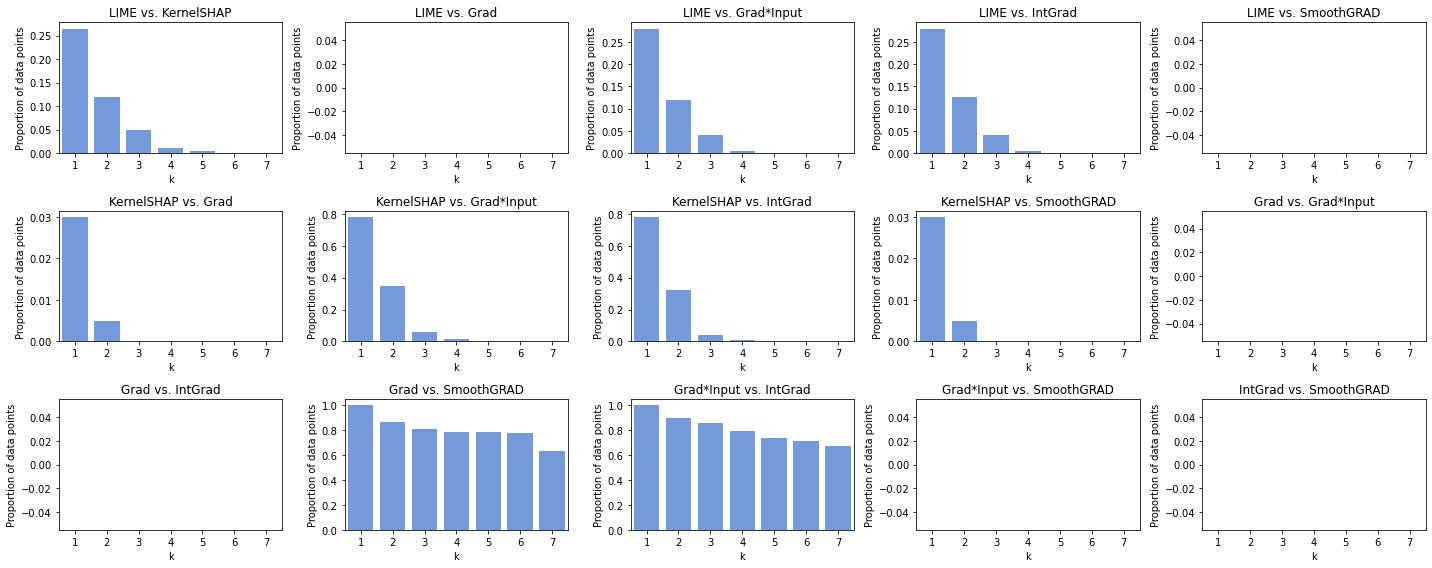

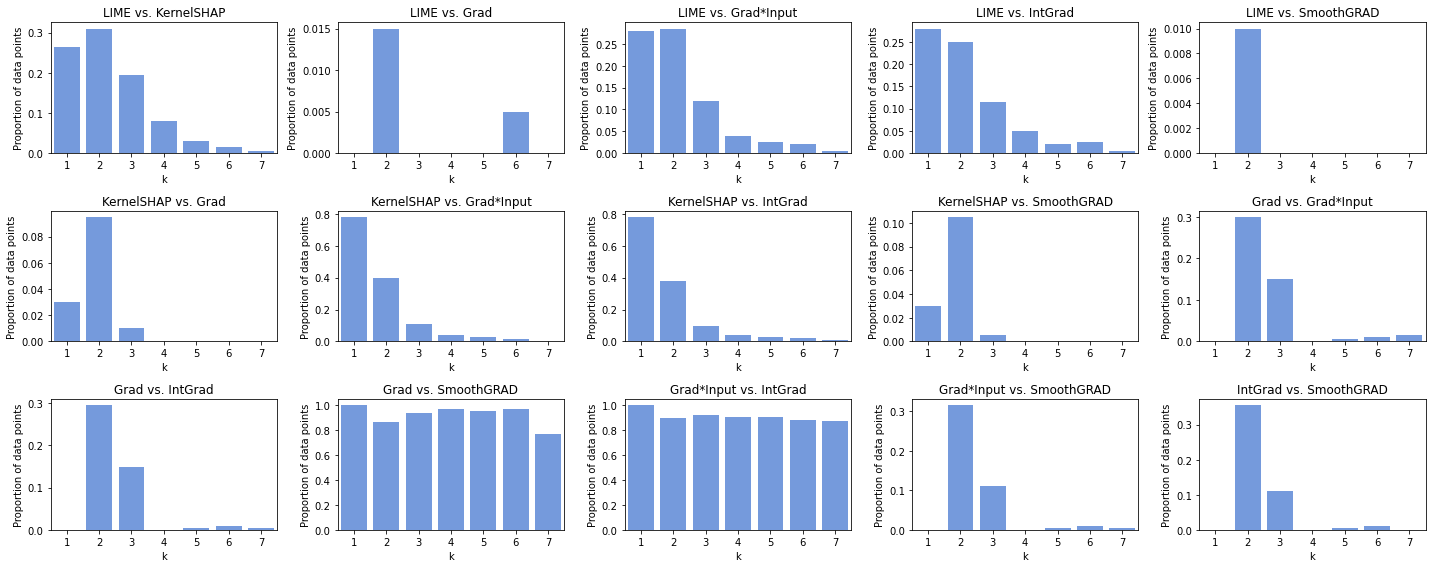

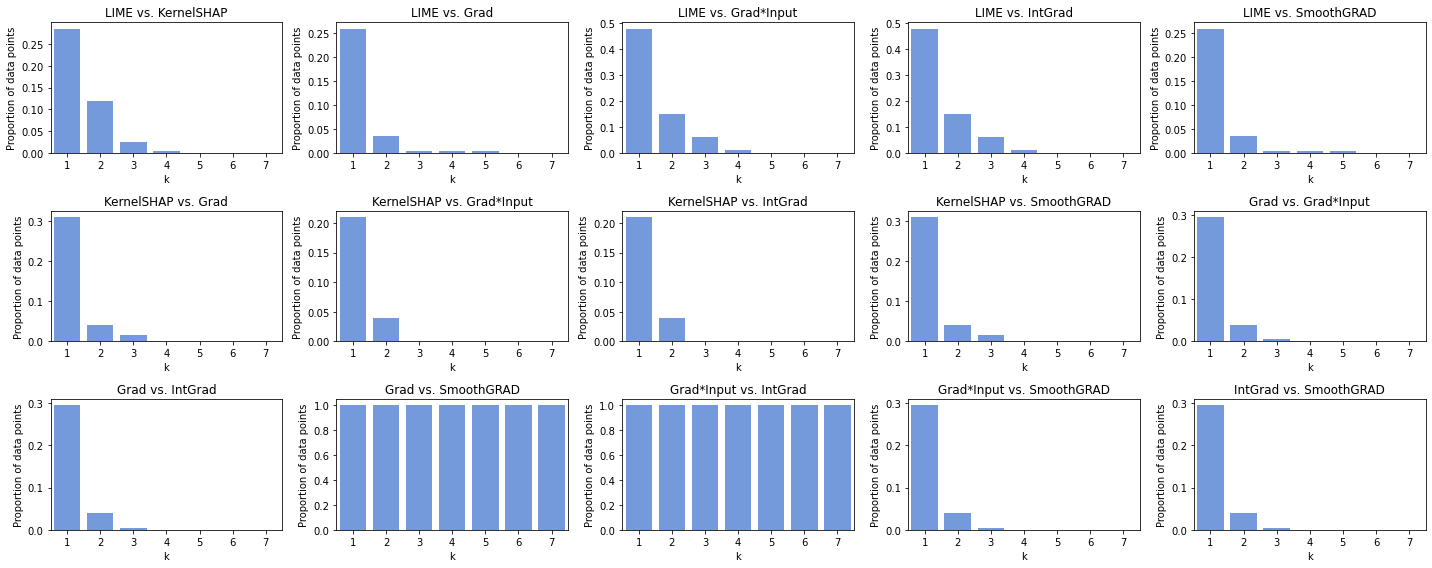

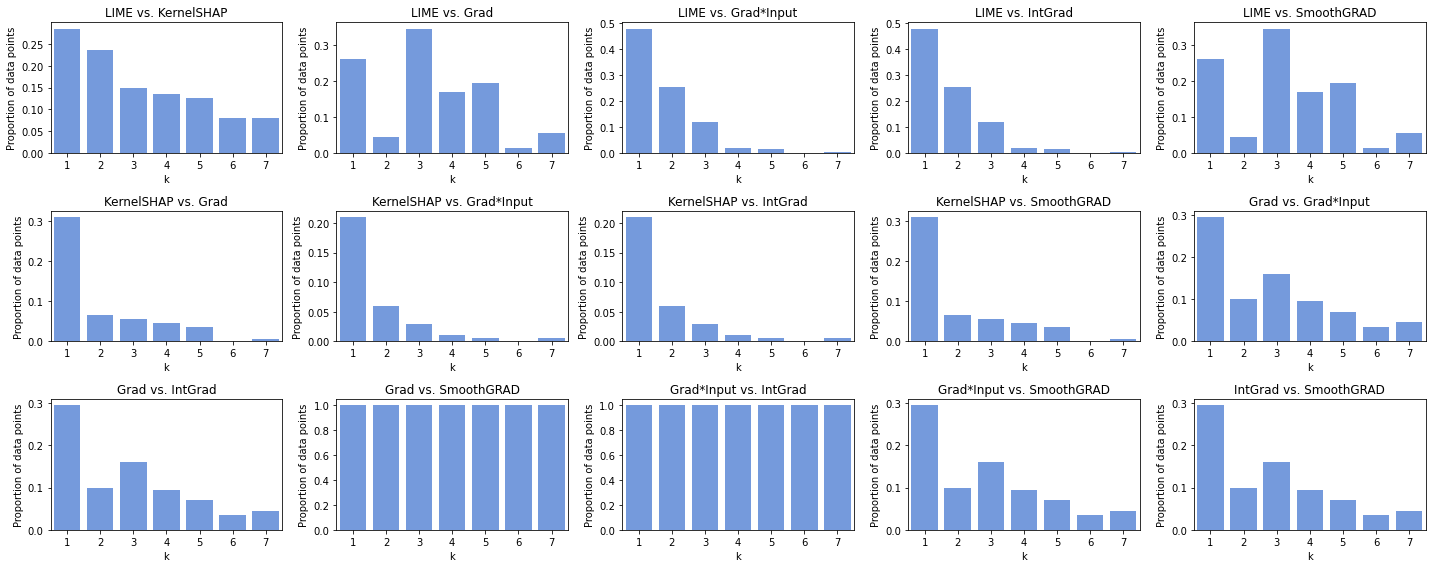

In [14]:
#barplots: 'strict' + 'lessstrict'

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
ks=[1, 2, 3, 4, 5, 6, 7]

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    for metric in ['strict', 'lessstrict']:
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_barplot_by_k_{metric}_{m}.png'
        plot_topk_barplots(expl_methods_names, expl_methods_attrs, ks, plot_path, topk_type=metric)


top k analysis: avgprop, nn, k=[1, 2, 3, 4, 5, 6, 7]
top k analysis: avgprop, nn_logistic, k=[1, 2, 3, 4, 5, 6, 7]


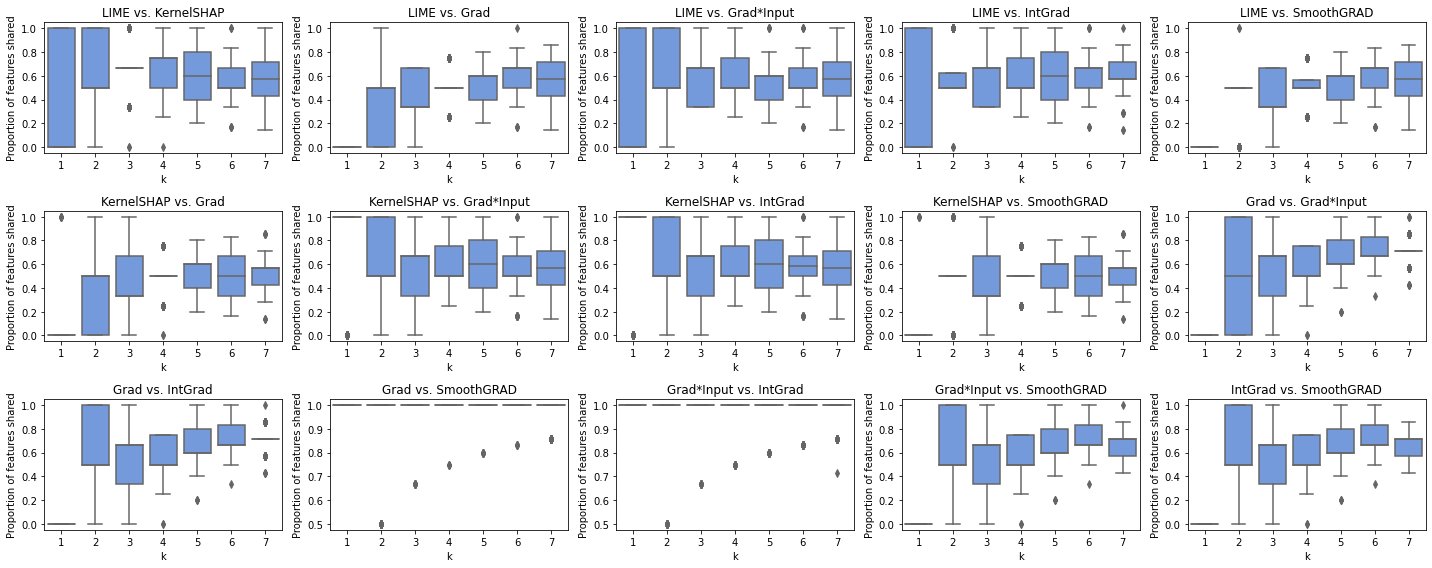

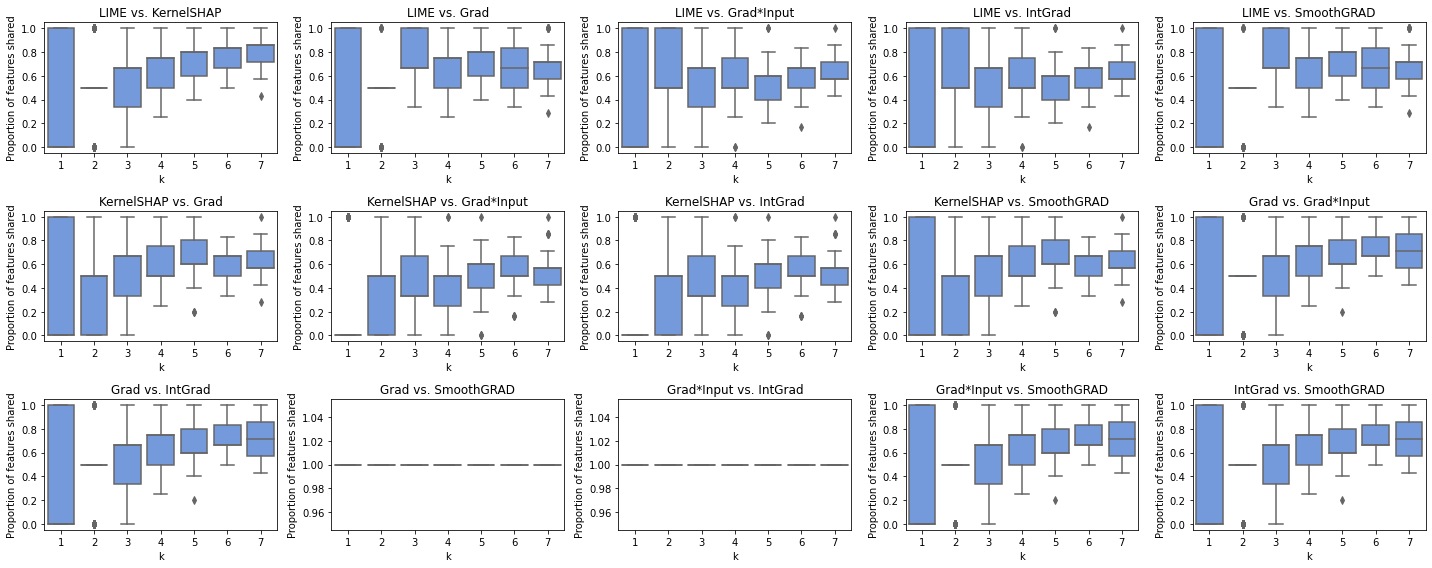

In [15]:
#boxplot: 'avgprop' 

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
ks=[1, 2, 3, 4, 5, 6, 7]

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    for metric in ['avgprop']:
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_boxplot_by_k_{metric}_{m}.png'
        plot_topk_boxplots(expl_methods_names, expl_methods_attrs, ks, plot_path)


### RF + GB

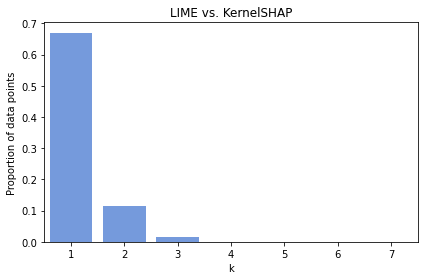

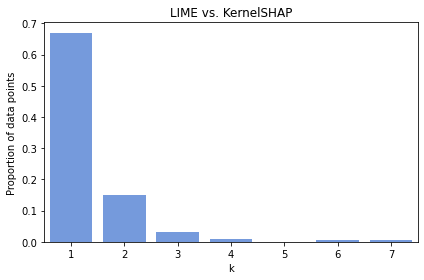

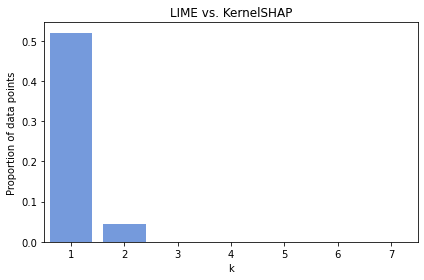

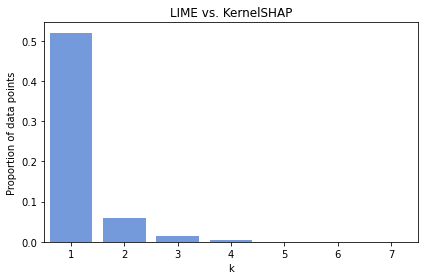

In [16]:
#barplots: 'strict' + 'lessstrict'

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
ks=[1, 2, 3, 4, 5, 6, 7]

for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    for metric in ['strict', 'lessstrict']:        
        #calculate values for plotting
        metrics_dict = calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks, topk_type=metric)

        #plot
        fig, axes = plt.subplots(1, 1, figsize =(6, 4))
        title, metric_values = list(metrics_dict.items())[0]
        sns.barplot(x=ks, y=metric_values, ax=axes, color='cornflowerblue')
        axes.set(xlabel='k', ylabel='Proportion of data points', title=title)
        fig.tight_layout()
        plot_path=f'figures/topk_barplot_by_k_{metric}_{m}.png'
        fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')


top k analysis: avgprop, rf, k=[1, 2, 3, 4, 5, 6, 7]
top k analysis: avgprop, gb, k=[1, 2, 3, 4, 5, 6, 7]


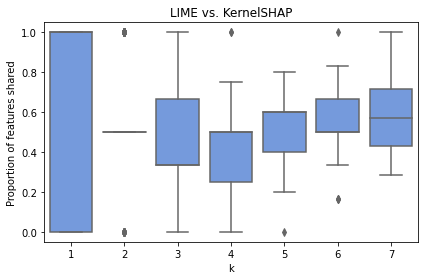

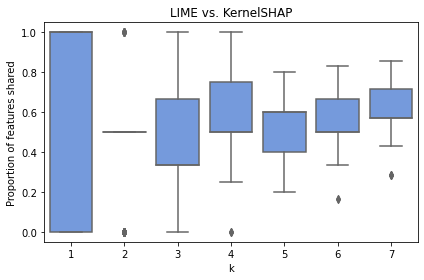

In [17]:
#boxplot: 'avgprop' 

expl_methods_names = {0: 'LIME',
                      1: 'KernelSHAP'}
ks=[1, 2, 3, 4, 5, 6, 7]

for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    for metric in ['avgprop']:
        print(f'top k analysis: {metric}, {m}, k={ks}')

        #calculate values for plotting
        metrics_dict = calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks, topk_type='avgprop')
        
        #plot
        fig, axes = plt.subplots(1, 1, figsize =(6, 4))
        title, metric_values = list(metrics_dict.items())[0]
        sns.boxplot(data=metric_values, ax=axes, color='cornflowerblue')
        axes.set_xticklabels(ks, rotation=0)
        axes.set(xlabel='k', ylabel='Proportion of features shared', title=title)
        fig.tight_layout()
        plot_path=f'figures/topk_boxplot_by_k_{metric}_{m}.png'
        fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')



# 3a. boxplots by method, functions

In [18]:
def plot_topk_barplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path, topk_type=['strict', 'lessstrict']):
    #function
    fig, axes = plt.subplots(1, 3, figsize =(18, 3))

    for i, k in enumerate(ks):
        #calculate rank corr
        metrics_dict = calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks=[k], topk_type=topk_type)
        #plot
        sns.barplot(data=list(metrics_dict.values()), color='cornflowerblue', ax=axes[i])
        axes[i].set(xlabel='Method pair', ylabel='Proportion of data points', title=f'k = {k}')
        xlabels =list(metrics_dict.keys())
        axes[i].set_xticklabels(xlabels, rotation=0 if len(xlabels)==1 else 90) 
        
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')


In [19]:
def plot_topk_boxplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path):
    #function
    fig, axes = plt.subplots(1, 3, figsize =(18, 3))

    for i, k in enumerate(ks):
        #calculate rank corr
        metrics_dict = calc_topk_agreement_all_methods_by_k(expl_methods_names, expl_methods_attrs, ks=[k], topk_type='avgprop')
        #plot
        sns.boxplot(data=list(metrics_dict.values()), color='cornflowerblue', ax=axes[i])
        axes[i].set(xlabel='Method pair', ylabel='Proportion of features shared', title=f'k = {k}')
        xlabels =list(metrics_dict.keys())
        axes[i].set_xticklabels(xlabels, rotation=0 if len(xlabels)==1 else 90) 
        
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight')


# 3b. boxplots by method, results

### NN + logistic

top k analysis: strict, nn, k=[3, 4, 5]
top k analysis: lessstrict, nn, k=[3, 4, 5]
top k analysis: strict, nn_logistic, k=[3, 4, 5]
top k analysis: lessstrict, nn_logistic, k=[3, 4, 5]


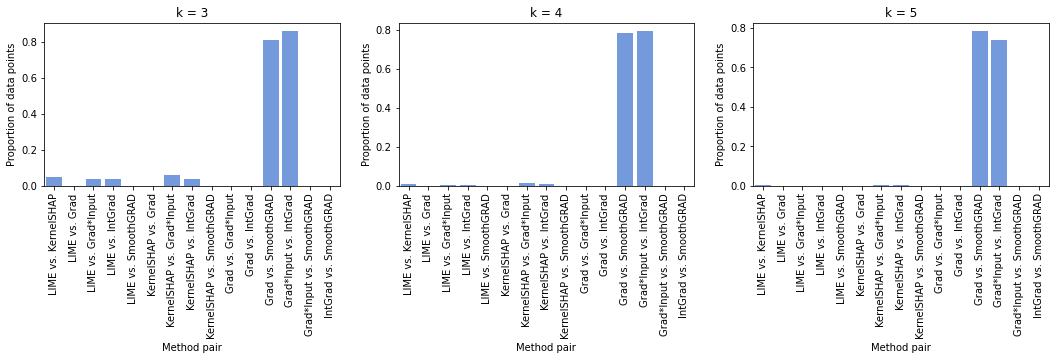

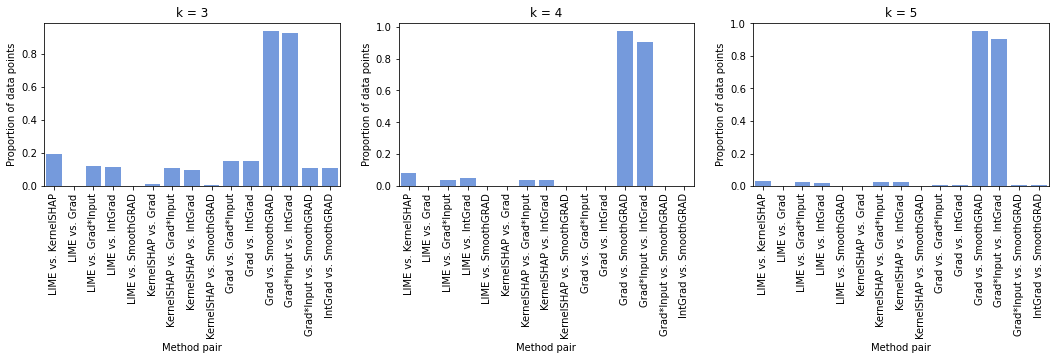

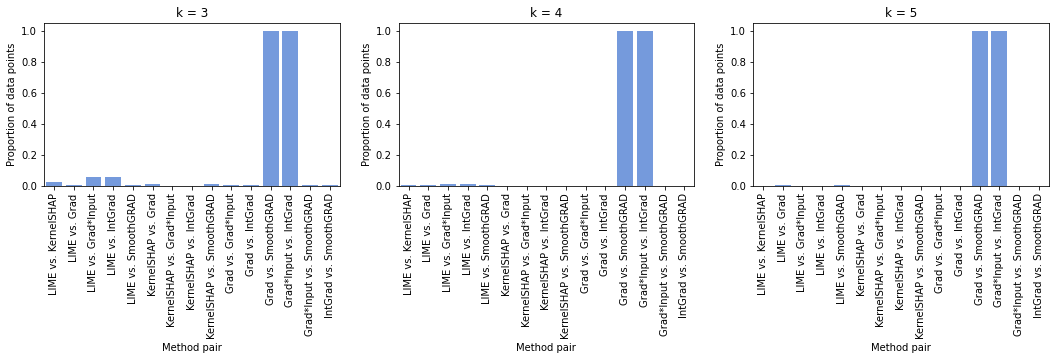

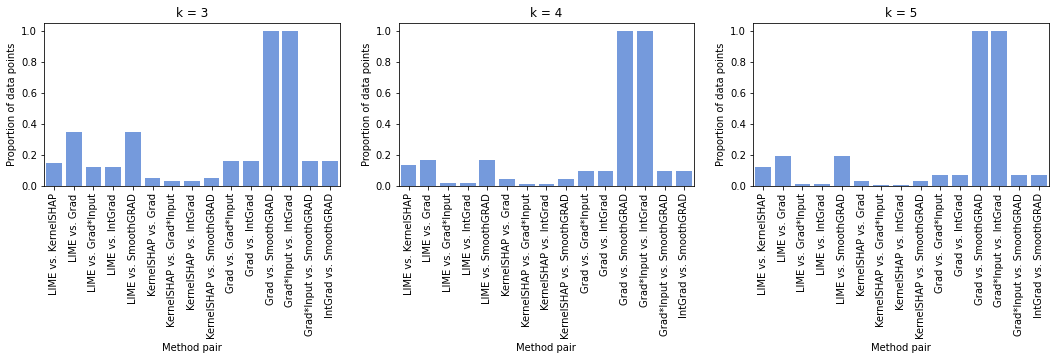

In [20]:
#barplots: 'strict' + 'lessstrict' 

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
ks=[3, 4, 5]

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    for metric in ['strict', 'lessstrict']:
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_barplot_by_method_{metric}_{m}.png'
        plot_topk_barplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path, topk_type=metric)


top k analysis: avgprop, nn, k=[3, 4, 5]
top k analysis: avgprop, nn_logistic, k=[3, 4, 5]


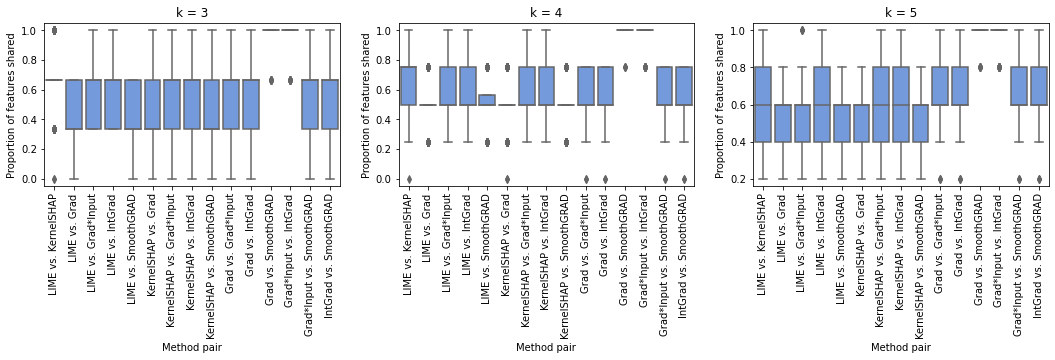

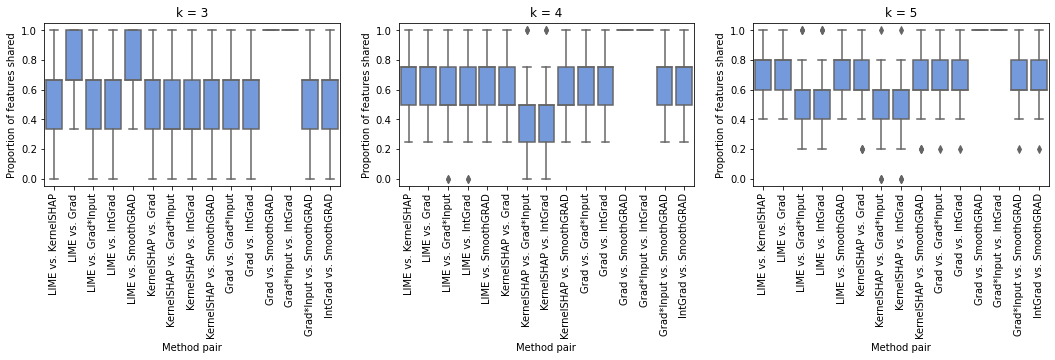

In [21]:
#boxplot: 'avgprop' 

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}
ks=[3, 4, 5]

for m in ['nn', 'nn_logistic']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m], 
                          2: attr_vanillagrad[m],
                          3: attr_gradtinput[m],
                          4: attr_integratedgrad[m],
                          5: attr_smoothgrad[m]}
    for metric in ['avgprop']:
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_boxplot_by_method_{metric}_{m}.png'
        plot_topk_boxplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path)


### RF + GB

top k analysis: strict, rf, k=[3, 4, 5]
top k analysis: lessstrict, rf, k=[3, 4, 5]
top k analysis: strict, gb, k=[3, 4, 5]
top k analysis: lessstrict, gb, k=[3, 4, 5]


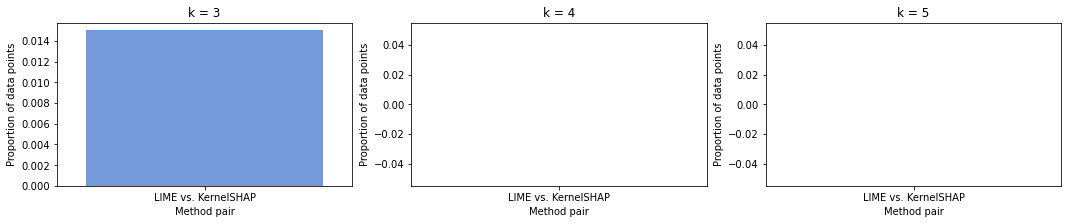

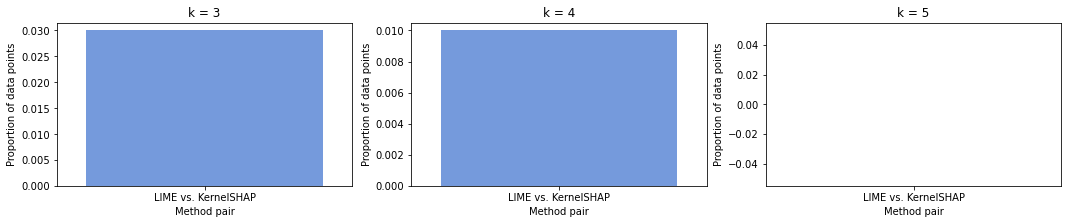

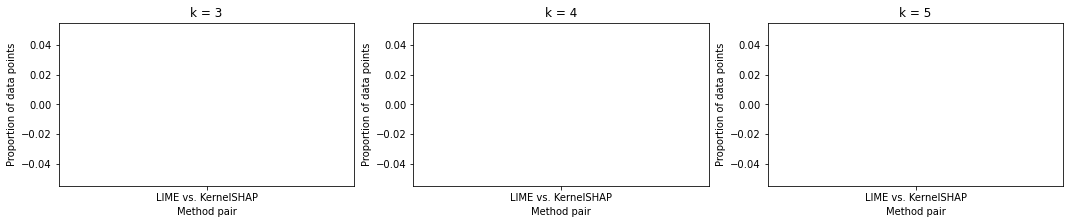

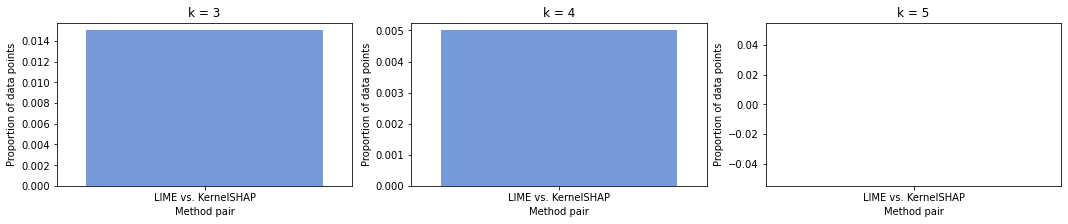

In [22]:
#barplots: 'strict' + 'lessstrict' 

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
ks=[3, 4, 5]

for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    for metric in ['strict', 'lessstrict']:
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_barplot_by_method_{metric}_{m}.png'
        plot_topk_barplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path, topk_type=metric)


top k analysis: avgprop, rf, k=[3, 4, 5]
top k analysis: avgprop, gb, k=[3, 4, 5]


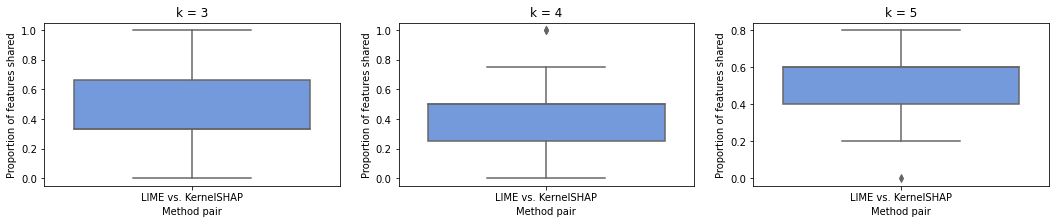

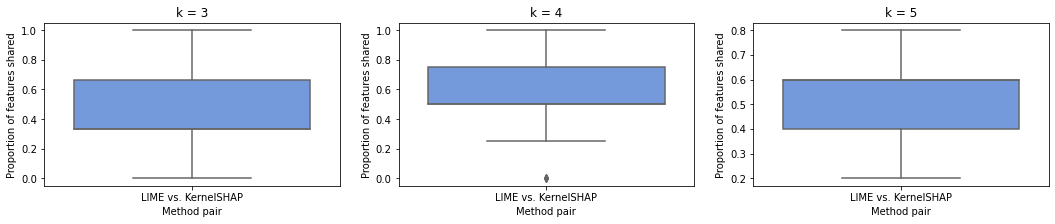

In [23]:
#boxplot: 'avgprop' 

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}
ks=[3, 4, 5]

for m in ['rf', 'gb']:
    expl_methods_attrs = {0: attr_lime[m],
                          1: attr_kernelshap[m]}
    for metric in ['avgprop']:
        print(f'top k analysis: {metric}, {m}, k={ks}')
        plot_path=f'figures/topk_boxplot_by_method_{metric}_{m}.png'
        plot_topk_boxplots_by_method(expl_methods_names, expl_methods_attrs, ks, plot_path)
